In [95]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def feedback_func(So=137.84, epsilon0 = 1, a0 = 0, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200,20,20), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
    Pc = 4e4              # depth of convection in Pa, called as Pa in the paper 
    P1 = 8e4                # highland surface pressure in Pa
    P4 = 1.05e5             # lowland surface pressure in Pa
    Z1 = 5e3                # height of highland in m
    Z4 = 0                  # height of lowland in m
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index==0:             # RCE case
            T1, T2, T3, T4, Fa, Fc1, Fc4 = p  
        elif solve_index==1:           # RE case
            T1, T2, T3, T4, Fa, Fc1 = p
            Fc4 = 0
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So - Fc1 + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = Fc1 - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4
        
        # Lowland atmos energy equation
        Eq4 = Fa + Fc4 + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        # Lowland surface energy equation
        Eq5 = So - Fc4 + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4                              
        
#         fc = cld_frc(Fc)
#         alpha_p = alpha(cld_frc(Fc))
#         a_2 = a(T2, q2)
#         FluxC = - (fc * (Flux1 + Flux2) - fc * sigma*Tc**4)    # cloud radiative effect
        
#         # dayside outgoing longwave radiation
#         OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[6] != 0:           # RCE case at lowland
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc4 <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:6]
            Fc4 = 0
            (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
                ier = 0
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:6]
        Fc4 = 0
        (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc4 <= 0:             # stable atmosphere, either case does not work
                ier = 0
                Fc4 = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc1, Fc4))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
    elif solve_index == 1:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc1, Fc4, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [96]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 242  # K
T2_init = 222  # K
T3_init = 222  # K
T4_init = 264  # K
Fa_init = 0  # W/m2
Fc1_init = 79  # W/m2
Fc4_init = 0  # W/m2

output = feedback_func(So=S, epsilon0 = 1, a0 = 0, LW = 'constant', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc1_init, Fc4_init),\
    output = 'debug')

print(output[3])
print(output[0])
print(output[3] - output[0])

We have a solution:  (242.54664205894525, 222.04860616765544, 222.04860616765544, 264.0617823310139, -4.3906451296618845e-16, 79.4505780481616, 0)
264.0617823310139
242.54664205894525
21.515140272068635


In [136]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def revised_func(So=137.84, epsilon0 = 1, a0 = 0, Fcir2 = 0, Fcir3 = 0, high_frac = 0.3056, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200,20,20), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
#     Pc = 4.5e4              # depth of convection in Pa, called as Pa in the paper 
#     P1 = 8.5e4                # highland surface pressure in Pa
#     P4 = 1.05e5             # lowland surface pressure in Pa
#     Z1 = 5e3                # height of highland in m
#     Z4 = 0                  # height of lowland in m
    Pc = 4e4                # depth of convection in Pa, called as Pa in the paper 
    P1 = 7.6e4                # highland surface pressure in Pa
    P4 = 1.1e5               # lowland surface pressure in Pa
    Z1 = 4546                # height of highland in m
    Z4 = 569                  # height of lowland in m
    
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index==0:             # RCE case
            T1, T2, T3, T4, Fa, Fc1, Fc4 = p  
        elif solve_index==1:           # RE case
            T1, T2, T3, T4, Fa, Fc1 = p
            Fc4 = 0
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        elif LW == 'gray':        
            kappa = epsilon0 / 1e5 * 3  # epsilon0 = 1 --> kappa = 0.00003
            epsilon_2 = kappa * P1 / g
            epsilon_3 = kappa * P4 / g
            if epsilon_3 > 1:
                epsilon_3 = 1
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So - Fc1 + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = Fc1 - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4 - Fcir2
        
        # Lowland atmos energy equation
        Eq4 = high_frac /(1-high_frac) *Fa + Fc4 + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4 - Fcir3

        # Lowland surface energy equation
        Eq5 = So - Fc4 + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = sigma*T4**4                              
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Z_a, Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[6] != 0:           # RCE case at lowland
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc4 <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:6]
            Fc4 = 0
            (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
                ier = 0
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:6]
        Fc4 = 0
        (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc4 <= 0:             # stable atmosphere, either case does not work
                ier = 0
                Fc4 = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc1, Fc4))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        Z_a, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
    elif solve_index == 1:
        Z_a, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4, 'Z_a': Z_a,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc1, Fc4, Z_a, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [149]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 242  # K
T2_init = 222  # K
T3_init = 222  # K
T4_init = 264  # K
Fa_init = 0  # W/m2
Fc1_init = 79  # W/m2
Fc4_init = 0  # W/m2

output = revised_func(So=S, epsilon0 = 1, a0 = 0, Fcir2 = 12.0747, Fcir3 = 12.0747, high_frac = 0.3056, LW = 'gray', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc1_init, Fc4_init),\
    output = 'debug')

print('Lowland surface temperature is:', (output[3]), 'K')
print('Highland surface temperature is:', (output[0]), 'K')
print('Atmos temperature is:', (output[1]), 'K')
print('Surface temperature difference is:', (output[3] - output[0]), 'K')
print('Highland surface emission is:', (output[8]), 'W/m2')
print('Highland atmos emission is:', (output[9]), 'W/m2')
print('Lowland atmos emission is:', (output[10]), 'W/m2')
print('Lowland surface emission is:', (output[11]), 'W/m2')
print('\n')
print('Atmospheric elevation is:', (output[7]), 'm')
# print('Highland surface budget is:', (S - output[5] + output[8] - output[7]), 'W/m2')
# print('Highland atmos budget is:', (+ output[5] - 2 * output[8] + output[7] - output[4] - 12), 'W/m2')
# print(output)

We have a solution:  (240.09333162603585, 207.56954032163105, 207.56954032163105, 251.66610348517972, -5.334240146996469, 21.969958658585014, 0)
Lowland surface temperature is: 251.66610348517972 K
Highland surface temperature is: 240.09333162603585 K
Atmos temperature is: 207.56954032163105 K
Surface temperature difference is: 11.57277185914387 K
Highland surface emission is: 188.409783815903 W/m2
Highland atmos emission is: 72.53974247451852 W/m2
Lowland atmos emission is: 89.60791717440523 W/m2
Lowland surface emission is: 227.44791448775726 W/m2


Atmospheric elevation is: 6742.094035264443 m


In [121]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def pressure_5_func(So=137.84, epsilon0 = 0.1, a0 = 0, Fcir2 = 0, Fcir3 = 0, high_frac = 0.3056, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200,20,20), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
#     Pc = 4.5e4              # depth of convection in Pa, called as Pa in the paper 
#     P1 = 8.5e4                # highland surface pressure in Pa
#     P4 = 1.05e5             # lowland surface pressure in Pa
#     Z1 = 5e3                # height of highland in m
#     Z4 = 0                  # height of lowland in m
    Pc = 2e5                # depth of convection in Pa, called as Pa in the paper 
    P1 = 3.8e5                # highland surface pressure in Pa
    P4 = 5.5e5                # lowland surface pressure in Pa
    Z1 = 4873                # height of highland in m
    Z4 = 754                  # height of lowland in m
    
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index==0:             # RCE case
            T1, T2, T3, T4, Fa, Fc1, Fc4 = p  
        elif solve_index==1:           # RE case
            T1, T2, T3, T4, Fa, Fc1 = p
            Fc4 = 0
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        elif LW == 'gray':        
            kappa = epsilon0 / 5e5 * 3  # epsilon0 = 1 --> kappa = 0.00003
            epsilon_2 = kappa * P1 / g
            epsilon_3 = kappa * P4 / g
            if epsilon_3 > 1:
                epsilon_3 = 1
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So - Fc1 + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = Fc1 - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4 - Fcir2
        
        # Lowland atmos energy equation
        Eq4 = high_frac /(1-high_frac) *Fa + Fc4 + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4 - Fcir3

        # Lowland surface energy equation
        Eq5 = So - Fc4 + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = sigma*T4**4                              
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[6] != 0:           # RCE case at lowland
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc4 <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:6]
            Fc4 = 0
            (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
                ier = 0
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:6]
        Fc4 = 0
        (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc4 <= 0:             # stable atmosphere, either case does not work
                ier = 0
                Fc4 = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc1, Fc4))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
    elif solve_index == 1:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc1, Fc4, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [139]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 210  # K
T2_init = 168  # K
T3_init = 168  # K
T4_init = 229  # K
Fa_init = 23  # W/m2
Fc1_init = 31  # W/m2
Fc4_init = 0  # W/m2

output = pressure_5_func(So=S, epsilon0 = 0.1, a0 = 0, Fcir2 = 9.6400, Fcir3 = 9.6400, high_frac = 0.3056, LW = 'gray', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc1_init, Fc4_init),\
    output = 'debug')

print('Lowland surface temperature is:', (output[3]), 'K')
print('Highland surface temperature is:', (output[0]), 'K')
print('Atmos temperature is:', (output[1]), 'K')
print('Surface temperature difference is:', (output[3] - output[0]), 'K')
print('Highland surface emission is:', (output[7]), 'W/m2')
print('Highland atmos emission is:', (output[8]), 'W/m2')
print('Lowland atmos emission is:', (output[9]), 'W/m2')
print('Lowland surface emission is:', (output[10]), 'W/m2')
print('\n')
print('Highland surface budget is:', (S - output[5] + output[8] - output[7]), 'W/m2')
print('Highland atmos budget is:', (+ output[5] - 2 * output[8] + output[7] - output[4] - 9.6400), 'W/m2')
print(output)

We have a solution:  (211.28717482375814, 182.43764556618476, 182.43764556618476, 224.27115586157822, 18.293374812942695, 28.71130090740801, 0)
Lowland surface temperature is: 224.27115586157822 K
Highland surface temperature is: 211.28717482375814 K
Atmos temperature is: 182.43764556618476 K
Surface temperature difference is: 12.983981037820087 K
Highland surface emission is: 112.99926099201261 W/m2
Highland atmos emission is: 3.8705618994181363 W/m2
Lowland atmos emission is: 5.602129064947303 W/m2
Lowland surface emission is: 143.44213619988273 W/m2


Highland surface budget is: -2.4726887204451486e-12 W/m2
Highland atmos budget is: 106.03606328764165 W/m2
(211.28717482375814, 182.43764556618476, 182.43764556618476, 224.27115586157822, 18.293374812942695, 28.71130090740801, 0, 112.99926099201261, 3.8705618994181363, 5.602129064947303, 143.44213619988273, {'nfev': 12, 'fjac': array([[-2.75649253e-03,  1.58601734e-04,  1.37483456e-04,
        -1.72157532e-03, -2.81614776e-19,  9.99994

In [140]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def pressure_0p1_func(So=137.84, epsilon0 = 0.1, a0 = 0, Fcir2 = 0, Fcir3 = 0, high_frac = 0.3056, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200,20,20), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
#     Pc = 4.5e4              # depth of convection in Pa, called as Pa in the paper 
#     P1 = 8.5e4                # highland surface pressure in Pa
#     P4 = 1.05e5             # lowland surface pressure in Pa
#     Z1 = 5e3                # height of highland in m
#     Z4 = 0                  # height of lowland in m
    Pc = 4.0e3                # depth of convection in Pa, called as Pa in the paper 
    P1 = 7.7e3                # highland surface pressure in Pa
    P4 = 1.1e4              # lowland surface pressure in Pa
    Z1 = 4873                # height of highland in m
    Z4 = 754                  # height of lowland in m
    
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index==0:             # RCE case
            T1, T2, T3, T4, Fa, Fc1, Fc4 = p  
        elif solve_index==1:           # RE case
            T1, T2, T3, T4, Fa, Fc1 = p
            Fc4 = 0
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        elif LW == 'gray':        
            kappa = epsilon0 / 1e4 * 3  # epsilon0 = 1 --> kappa = 0.00003
            epsilon_2 = kappa * P1 / g
            epsilon_3 = kappa * P4 / g
            if epsilon_3 > 1:
                epsilon_3 = 1
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So - Fc1 + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = Fc1 - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4 - Fcir2
        
        # Lowland atmos energy equation
        Eq4 = high_frac /(1-high_frac) *Fa + Fc4 + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4 - Fcir3

        # Lowland surface energy equation
        Eq5 = So - Fc4 + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = sigma*T4**4                              
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Z_a, Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[6] != 0:           # RCE case at lowland
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc4 <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:6]
            Fc4 = 0
            (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
                ier = 0
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:6]
        Fc4 = 0
        (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc4 <= 0:             # stable atmosphere, either case does not work
                ier = 0
                Fc4 = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc1, Fc4))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        Z_a, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
    elif solve_index == 1:
        Z_a, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4, 'Z_a': Z_a,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc1, Fc4, Z_a, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [141]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 242  # K
T2_init = 222  # K
T3_init = 222  # K
T4_init = 264  # K
Fa_init = 0  # W/m2
Fc1_init = 79  # W/m2
Fc4_init = 0  # W/m2

output = pressure_0p1_func(So=S, epsilon0 = 0.1, a0 = 0, Fcir2 = 4.4267, Fcir3 = 4.4267, high_frac = 0.3056, LW = 'gray', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc1_init, Fc4_init),\
    output = 'debug')

print('Lowland surface temperature is:', (output[3]), 'K')
print('Highland surface temperature is:', (output[0]), 'K')
print('Atmos temperature is:', (output[1]), 'K')
print('Surface temperature difference is:', (output[3] - output[0]), 'K')
print('Highland surface emission is:', (output[8]), 'W/m2')
print('Highland atmos emission is:', (output[9]), 'W/m2')
print('Lowland atmos emission is:', (output[10]), 'W/m2')
print('Lowland surface emission is:', (output[11]), 'W/m2')
print('\n')
print('Amospheric elevation is:', (output[7]), 'm')
# print('Highland surface budget is:', (S - output[5] + output[8] - output[7]), 'W/m2')
# print('Highland atmos budget is:', (+ output[5] - 2 * output[8] + output[7] - output[4] - 12), 'W/m2')

We have a solution:  (217.84539462476684, 187.5787699446326, 187.5787699446326, 224.52816922136978, 9.30730361821798, 14.526768219274388, 0)
Lowland surface temperature is: 224.52816922136978 K
Highland surface temperature is: 217.84539462476684 K
Atmos temperature is: 187.5787699446326 K
Surface temperature difference is: 6.68277459660294 K
Highland surface emission is: 127.69579358366283 W/m2
Highland atmos emission is: 4.382561802937142 W/m2
Lowland atmos emission is: 6.2608025756244885 W/m2
Lowland surface emission is: 144.10080257005094 W/m2


Amospheric elevation is: 6274.189494503505 m


In [142]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def pressure_0p01_func(So=137.84, epsilon0 = 0.1, a0 = 0, Fcir2 = 0, Fcir3 = 0, high_frac = 0.3056, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200,20,20), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
#     Pc = 4.5e4              # depth of convection in Pa, called as Pa in the paper 
#     P1 = 8.5e4                # highland surface pressure in Pa
#     P4 = 1.05e5             # lowland surface pressure in Pa
#     Z1 = 5e3                # height of highland in m
#     Z4 = 0                  # height of lowland in m
    Pc = 430                # depth of convection in Pa, called as Pa in the paper 
    P1 = 890                # highland surface pressure in Pa
    P4 = 1300              # lowland surface pressure in Pa
    Z1 = 4873                # height of highland in m
    Z4 = 754                  # height of lowland in m
    
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index==0:             # RCE case
            T1, T2, T3, T4, Fa, Fc1, Fc4 = p  
        elif solve_index==1:           # RE case
            T1, T2, T3, T4, Fa, Fc1 = p
            Fc4 = 0
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        elif LW == 'gray':        
            kappa = epsilon0 / 1e4 * 3  # epsilon0 = 1 --> kappa = 0.00003
            epsilon_2 = kappa * P1 / g
            epsilon_3 = kappa * P4 / g
            if epsilon_3 > 1:
                epsilon_3 = 1
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So - Fc1 + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = Fc1 - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4 - Fcir2
        
        # Lowland atmos energy equation
        Eq4 = high_frac /(1-high_frac) *Fa + Fc4 + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4 - Fcir3

        # Lowland surface energy equation
        Eq5 = So - Fc4 + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = sigma*T4**4                              
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[6] != 0:           # RCE case at lowland
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc4 <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:6]
            Fc4 = 0
            (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
                ier = 0
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:6]
        Fc4 = 0
        (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc4 <= 0:             # stable atmosphere, either case does not work
                ier = 0
                Fc4 = 0
                solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc1, Fc4))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
    elif solve_index == 1:
        Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc1, Fc4, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [144]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 242  # K
T2_init = 222  # K
T3_init = 222  # K
T4_init = 264  # K
Fa_init = 0  # W/m2
Fc1_init = 79  # W/m2
Fc4_init = 0  # W/m2

output = pressure_0p1_func(So=S, epsilon0 = 0.1, a0 = 0, Fcir2 = 1.4294, Fcir3 = 1.4294, high_frac = 0.3056, LW = 'gray', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc1_init, Fc4_init),\
    output = 'debug')

print('Lowland surface temperature is:', (output[3]), 'K')
print('Highland surface temperature is:', (output[0]), 'K')
print('Atmos temperature is:', (output[1]), 'K')
print('Surface temperature difference is:', (output[3] - output[0]), 'K')
print('Highland surface emission is:', (output[7]), 'W/m2')
print('Highland atmos emission is:', (output[8]), 'W/m2')
print('Lowland atmos emission is:', (output[9]), 'W/m2')
print('Lowland surface emission is:', (output[10]), 'W/m2')
print('\n')
print('Highland surface budget is:', (S - output[5] + output[8] - output[7]), 'W/m2')
print('Highland atmos budget is:', (+ output[5] - 2 * output[8] + output[7] - output[4] - 12), 'W/m2')
print(output)

We have a solution:  (221.2933358348048, 190.5476670936146, 190.5476670936146, 224.68610647129353, 4.258954508376854, 6.532513127391772, 0)
Lowland surface temperature is: 224.68610647129353 K
Highland surface temperature is: 221.2933358348048 K
Atmos temperature is: 190.5476670936146 K
Surface temperature difference is: 3.3927706364887342 K
Highland surface emission is: 6373.494033646727 W/m2
Highland atmos emission is: 135.97416512033146 W/m2
Lowland atmos emission is: 4.666678247723211 W/m2
Lowland surface emission is: 6.666683211033159 W/m2


Highland surface budget is: -6106.212381653788 W/m2
Highland atmos budget is: 6091.819262025079 W/m2
(221.2933358348048, 190.5476670936146, 190.5476670936146, 224.68610647129353, 4.258954508376854, 6.532513127391772, 0, 6373.494033646727, 135.97416512033146, 4.666678247723211, 6.666683211033159, 144.50668321014274, {'nfev': 15, 'fjac': array([[-3.75917272e-03,  2.85234466e-04, -5.42630073e-03,
         6.16386802e-02, -3.47453317e-18,  9.98076

In [34]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def nosh_func(So=137.84, epsilon0 = 1, a0 = 0, Fcir2 = 0, Fcir3 = 0, high_frac = 0.3056, LW = 'constant', SW = 'constant', p_guess=(250,250,200,200,200), output = 'default'):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 3.7                 # gravity in m/s2
    Pc = 5.5e4              # depth of convection in Pa, called as Pa in the paper 
    P1 = 8e4                # highland surface pressure in Pa
    P4 = 1.05e5             # lowland surface pressure in Pa
    Z1 = 5e3                # height of highland in m
    Z4 = 0                  # height of lowland in m
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # Fraction of heat transport to the nightside deposited in the boundary layer (should be ignored)
    k2 = 5000               # Relates water vapor to the infrared opacity (no use this case)
    k3 = 0.08               # relates the strength of convection to the cloud fraction (no use this case)
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT) (no use this case)

    ### Constants for water vapor calculations    
    RH1 = 0           # Highland surface relative humidity
    RH2 = 0           # Highland atmosphere relative humidity
    RH3 = 0           # Lowland atmosphere relative humidity
    RH4 = 0           # Lowland surface relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.044      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 767                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0
        return alpha_p
    
    def cld_frc(Fc):
        if Fc <= 0:                    # cloud fraction should always be positive
            fc = 0
        else:
            fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
            fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def a(T, q):        
        if SW == 'feedback':
            if q < 0:
                q = 0
            a = 1 - np.exp(-k2*q/1e2)
        elif SW == 'ideal': # temperature varying absorption
            ka = 10e3      # exponetional factor (like CC relation)
            T_ref = 280   # Temperature of full absorption limit 
            a_ref = 0.9      # Max water vapor absorption to sunlight
            if T <= T_ref:
                a = a_ref*np.exp(-ka*(1/T - 1/T_ref))
            else:
                a = a_ref
        elif SW == 'constant':
            a = a0
        return a
    
    def sp(T, P, RH):
        q = 0
        qs = 0
        return q, qs
    
    def IR_absorption(temperature):
        temperature_ref = 330   # Temperature of full absorption limit 
        absorption_ref = 0.9      # Max water vapor absorption to IR
        ke = 1e3      # exponential factor (like CC relation)
        a = np.zeros_like(temperature)
        mask = temperature <= temperature_ref
        a[mask] = absorption_ref * np.exp(-ke * (1 / temperature[mask] - 1 / temperature_ref))
        a[~mask] = absorption_ref
        return a
    
    def check_MSE(Ts, Ta, Ps, Zs):
        qs, qs_s = sp(Ts, Ps, 0)
        qa, qa_s = sp(Ta, Pc, 0)      
        Cps = Cpd  
        Cpa = Cpd  
        Z_a = np.log(Ps/Pc)*((R_star/mm_dry)*Ta)/g       
        if Cps*Ts + L*qs + g*Zs - (Cpa*Ta + L*qa_s + g*(Z_a + Z1)) >= 0:  # convection is going to happen
            return 0
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        T1, T2, T3, T4, Fa = p  
        
        # water vapor calculations for highland surface
        q1, q1_s = sp(T1, P1, RH1)
        # water vapor calcaulations for highland atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for lowland atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        # water vapor calculations for lowland surface
        q4, q4_s = sp(T4, P4, RH4)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        Cp3 = Cpd*(1 - q3) + Cpv * q3  # specific heat of mixed air at nightside surf
        Cp4 = Cpd*(1 - q4) + Cpv * q4  # specific heat of mixed air at nightside atmos
        
        if LW == 'feedback':
            if q2 < 0:
                q2 = 0
            if q3 < 0:
                q3 = 0
            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'ideal':
            epsilon_2 = IR_absorption(T2)
            epsilon_3 = IR_absorption(T3)
        elif LW == 'constant':
            epsilon_2 = epsilon0
            epsilon_3 = epsilon0
        
#         Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       
        Z_a = np.log(P1/Pc)*H
        Z2 = Z_a + Z1       # convection height at highland
        Z3 = Z2
                                   
        # Highland surface energy equation
        Eq2 = So  + epsilon_2*sigma*T2**4 - sigma*T1**4

        # Highland atmos energy equation
        Eq3 = - Fa + epsilon_2*sigma*T1**4 - 2*epsilon_2*sigma*T2**4 - Fcir2
        
        # Lowland atmos energy equation
        Eq4 = high_frac /(1-high_frac) *Fa + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4 - Fcir3

        # Lowland surface energy equation
        Eq5 = So + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        # weak temperature gradient assumption                           
        Eq6 = T2 - T3      

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        Eq8 = Cp4*T4 + L*q4 + g*Z4 - (Cp3*T3+L*q3_s + g*Z3)   # convective neutrality by temperature

        # other outputs
        Flux1 = sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = sigma*T4**4                              
        
        if output_index == 0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6)
#             if solve_index==0:
#                 return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7, Eq8)
#             elif solve_index==1:
#                 return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        elif output_index==1:
            return(Flux1, Flux2, Flux3, Flux4)
        
    # Solve the equations using fsolve function
    output_index = 0
    (T1, T2, T3, T4, Fa), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    
#     # two-step calculations
#     if p_guess[6] != 0:           # RCE case at lowland
#         solve_index = 0
#         (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#         if Fc4 <= 0:               # stable atmosphere, switch to RE
#             solve_index = 1       
#             new_p_guess = p_guess[:6]
#             Fc4 = 0
#             (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
#             if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, either case does not work
#                 ier = 0
#                 solve_index = 0     # switch back to RCE
#     else:   # if RE, no convection
#         solve_index = 1
#         new_p_guess = p_guess[:6]
#         Fc4 = 0
#         (T1, T2, T3, T4, Fa, Fc1), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
#         if check_MSE(T4, T3, P4, Z4) == 0:   # convection is going to happen, switch to RCE
#             solve_index = 0
#             (T1, T2, T3, T4, Fa, Fc1, Fc4), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#             if Fc4 <= 0:             # stable atmosphere, either case does not work
#                 ier = 0
#                 Fc4 = 0
#                 solve_index = 1     # switch back to RE
    
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa))
#     if solve_index == 0:
#         Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1, Fc4))
#     elif solve_index == 1:
#         Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc1))
    
#     outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc1': Fc1, 'Fc4': Fc4,
#                'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
#                'info': info, 'ier': ier, 'msg': msg}
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Flux1, Flux2, Flux3, Flux4, info, ier, msg
#         return T1, T2, T3, T4, Fa, Fc1, Fc4, Flux1, Flux2, Flux3, Flux4, info, ier, msg
    else:
        return outputs

In [140]:
# Example debug mode
S = 137.84       # W/m2
T1_init = 242  # K
T2_init = 222  # K
T3_init = 222  # K
T4_init = 264  # K
Fa_init = 0  # W/m2

output = nosh_func(So=S, epsilon0 = 0.0087, a0 = 0, Fcir2 = -0.0064, Fcir3 = -0.0577, high_frac = 0.5, \
                   LW = 'constant', SW = 'constant',\
    p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init),\
    output = 'debug')

print(output[3])
print(output[0])
print(output[3] - output[0])

We have a solution:  (222.2972031808245, 188.16009125095377, 188.16009125095377, 222.29720318081343, -0.02564999999999999)
222.29720318081343
222.2972031808245
-1.1084466677857563e-11


In [37]:
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'epsilon_2': math.nan, 'epsilon_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
                 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    output = feedback_func(So = s, epsilon0 = 0.5, a0 = 0.8, LW = 'ideal', SW = 'feedback', \
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution \n")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        cold_list.append(nan_dict)
              
    else:
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

0 800.0


IndexError: tuple index out of range

In [11]:
# # print(output_list)
# print(output_list[1]['T1'])
# for output in output_list:
#     print(output['T1'])
    
# extract all T1 values from output_list
Fc_values = np.array([d['Fc'] for d in cold_list])

# print the resulting array
print(Fc_values)

[ 99.4642022  102.82360875 106.53264302 110.55934977 114.87242458
 119.43921929 124.22460747 129.19050433 134.29584127 139.49681502
 144.74726431 149.99906539 155.20247502 160.30637957 165.25843101
 170.00506351 174.49139083 178.66098511 182.45553416 185.8143671
 188.67382744 190.96645685 192.61992879 193.55563952 193.68679803
 192.91577282 191.13027038 188.19760732 183.95569354 178.19795674
 170.64611943 160.89572087 148.28983961 131.54923641 107.04179381]


In [12]:
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
warm_list = []

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
                 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    output = feedback_func(So = s, epsilon0 = 0.5, a0 = 0.8, LW = 'ideal', SW = 'feedback', \
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution \n")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        warm_list.append(nan_dict)
              
    else:
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        warm_list.append(output)

0 2500.0
We have a solution:  (309.14463889590644, 317.29378771160015, 317.29378771160015, 317.05800363615634, 574.3381808600417, 0)
The average atmosphere-surface energy ratio is: 1.0536363236703836


1 2450.0
We have a solution:  (309.2573250078677, 315.69036041151065, 315.69036041151065, 314.40348799764985, 561.1886783671542, 0)
The average atmosphere-surface energy ratio is: 1.0500114942667012


2 2400.0
We have a solution:  (309.8573014831143, 313.99602037344624, 313.99602037344624, 311.5992978668536, 547.3560245799197, 0)
The average atmosphere-surface energy ratio is: 1.0426843789132123


3 2350.0
We have a solution:  (311.01140203945863, 312.1846406763583, 312.1846406763583, 308.6024280903509, 532.6516991979862, 0)
The average atmosphere-surface energy ratio is: 1.030961183581472


4 2300.0
We have a solution:  (312.795385121803, 310.2201077935487, 310.2201077935487, 305.3534679269601, 516.8174833439571, 0)
The average atmosphere-surface energy ratio is: 1.014028049823236


5 2

In [13]:
# extract all T1 values from output_list
T1_cold = np.array([d['T1'] for d in cold_list])
T1_warm = np.array([d['T1'] for d in warm_list])

T2_cold = np.array([d['T2'] for d in cold_list])
T2_warm = np.array([d['T2'] for d in warm_list])

T3_cold = np.array([d['T3'] for d in cold_list])
T3_warm = np.array([d['T3'] for d in warm_list])

T4_cold = np.array([d['T4'] for d in cold_list])
T4_warm = np.array([d['T4'] for d in warm_list])

fc_cold = np.array([d['fc'] for d in cold_list])
fc_warm = np.array([d['fc'] for d in warm_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])
ap_warm = np.array([d['alpha_p'] for d in warm_list])

e2_cold = np.array([d['epsilon_2'] for d in cold_list])
e2_warm = np.array([d['epsilon_2'] for d in warm_list])

a2_cold = np.array([d['a_2'] for d in cold_list])
a2_warm = np.array([d['a_2'] for d in warm_list])

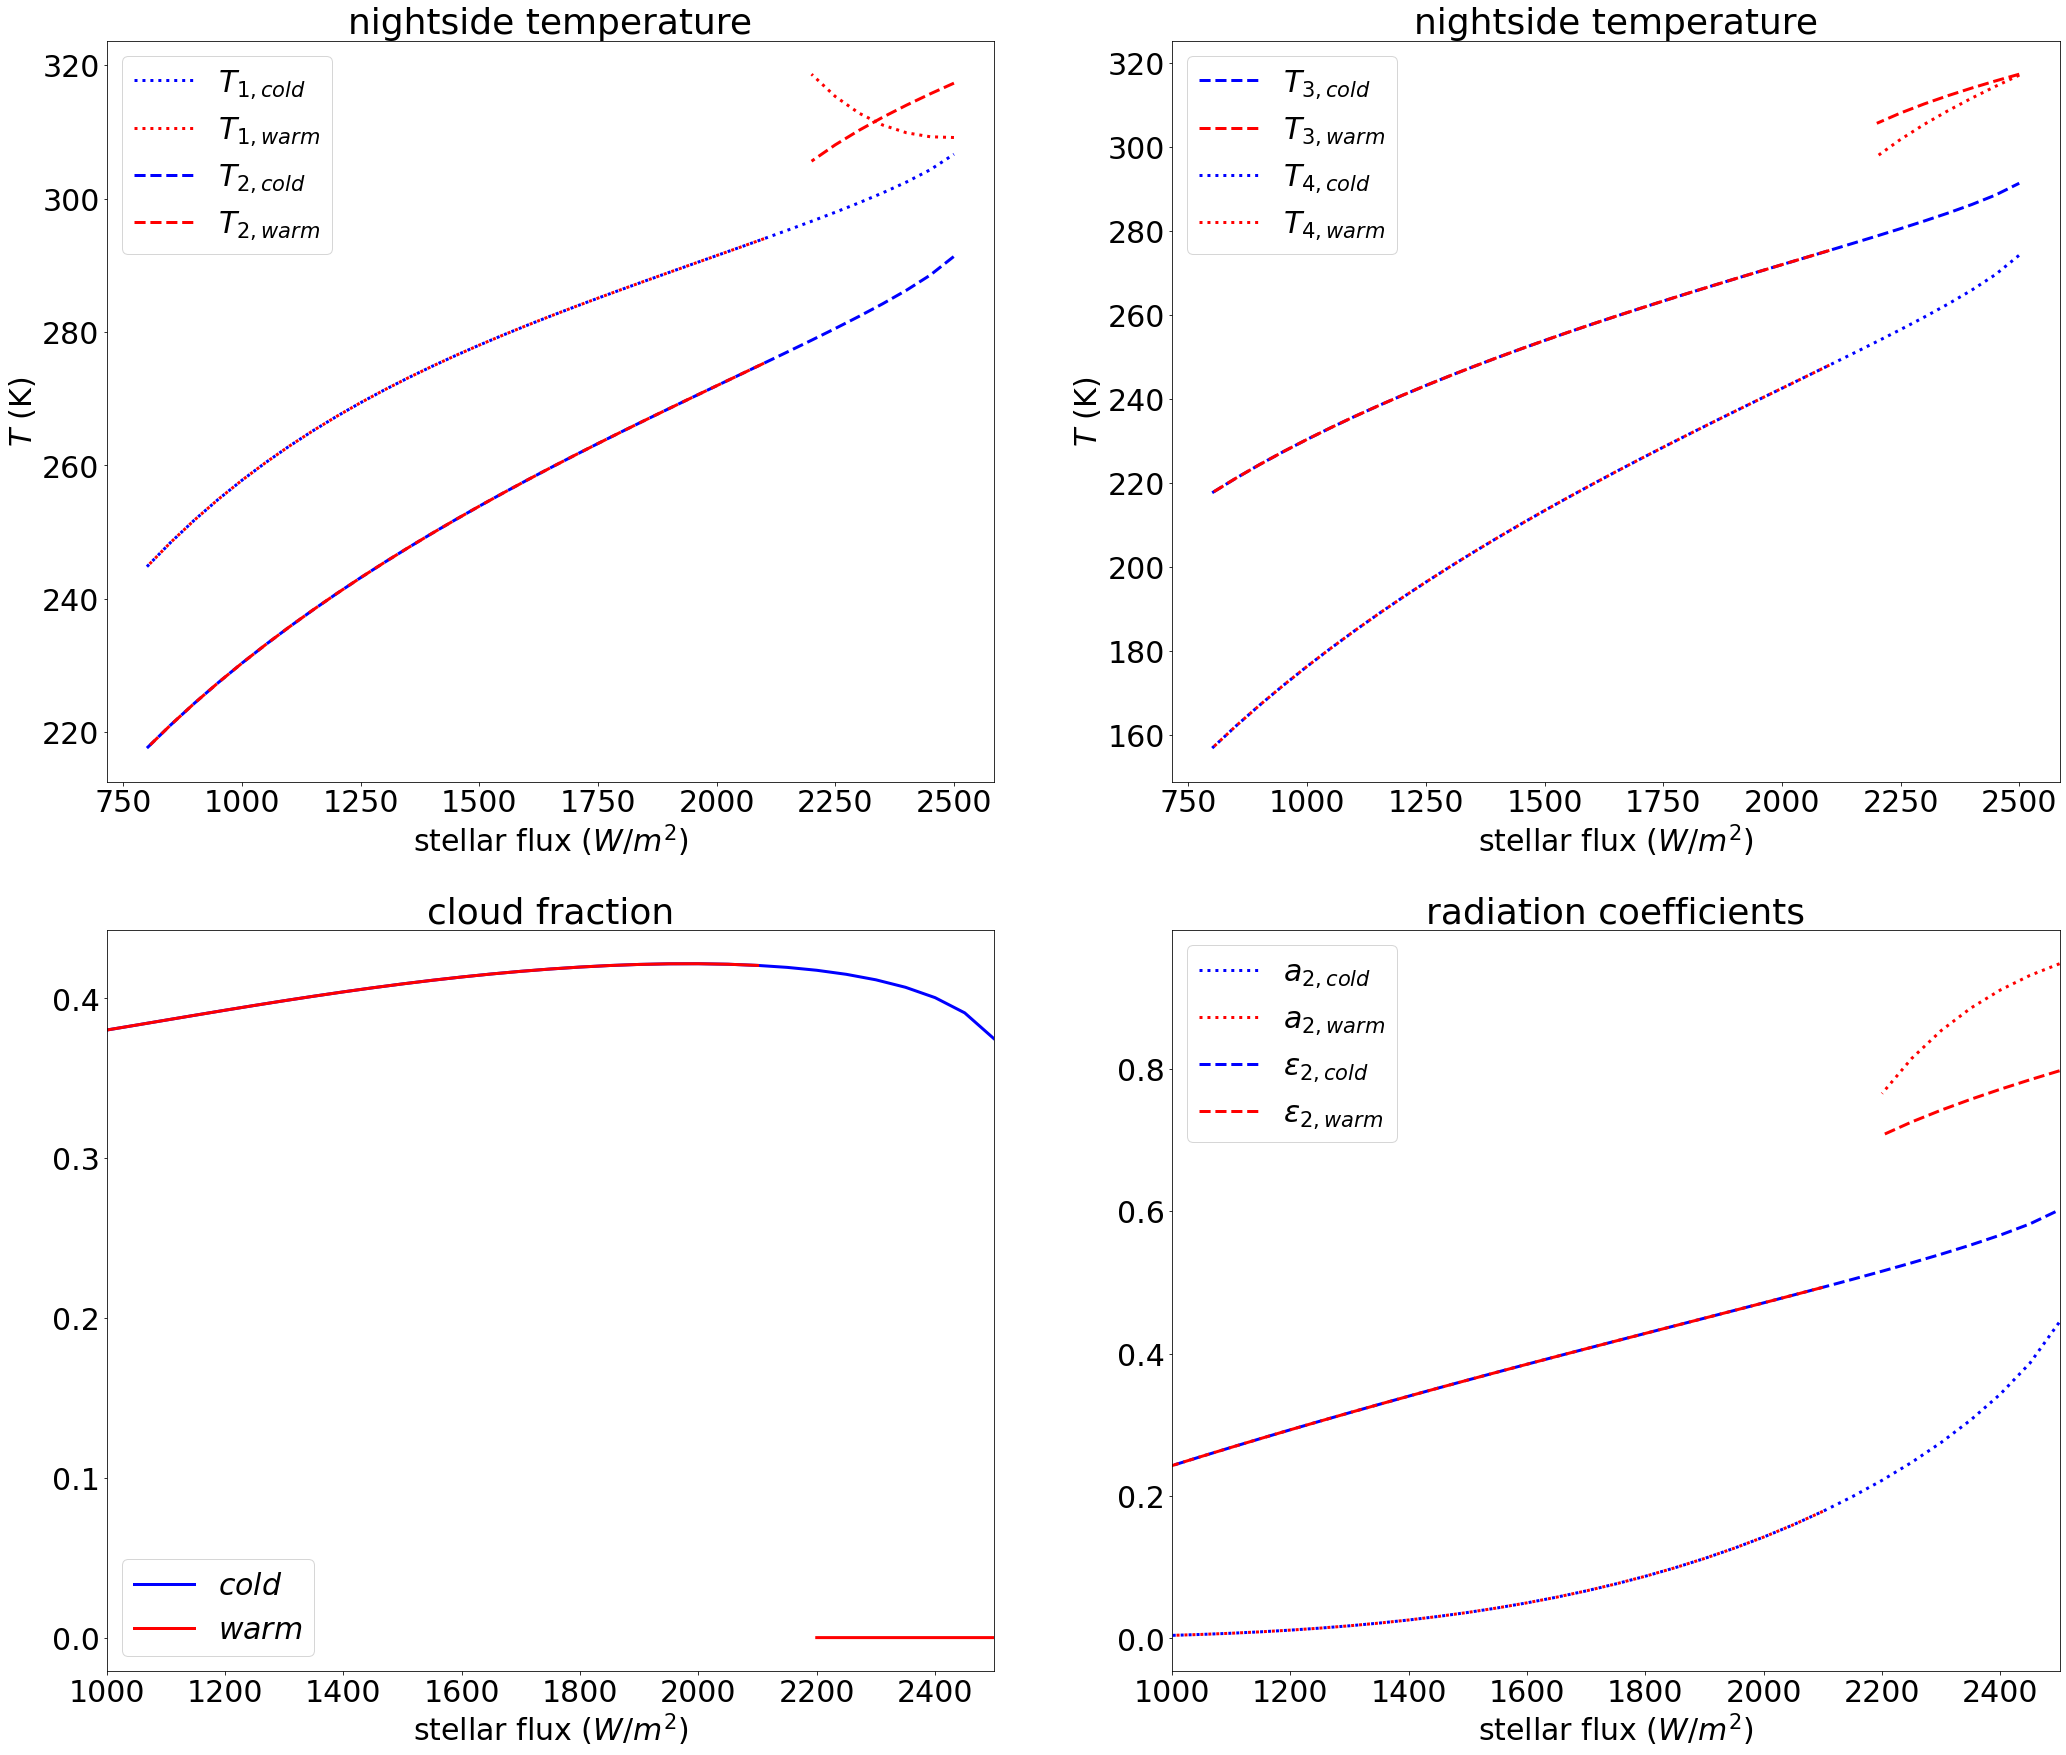

In [14]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,30)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_cold, ':', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[0,0].plot(so, T1_warm, ':', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[0,0].plot(np.flip(so), T2_cold, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[0,0].plot(so, T2_warm, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'nightside temperature')
    ax[0,0].legend()
    
#     # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T3_cold, '--', color = 'blue',linewidth=3, label = r'$T_{3, cold}$')
    ax[0,1].plot(so, T3_warm, '--', color = 'red', linewidth=3, label = r'$T_{3, warm}$')
    ax[0,1].plot(np.flip(so), T4_cold, ':', color = 'blue', linewidth=3, label = r'$T_{4, cold}$')
    ax[0,1].plot(so, T4_warm, ':', color = 'red',linewidth=3, label = r'$T_{4, warm}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'nightside temperature')
    ax[0,1].legend()
    
#     # Dayside energy budgets
    ax[1,0].plot(np.flip(so), fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[1,0].plot(so, fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_title('cloud fraction')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
#     # Dayside energy budgets
    ax[1,1].plot(np.flip(so), a2_cold,':', color = 'blue',linewidth=3, label = r'$a_{2, cold}$')
    ax[1,1].plot(so, a2_warm,':',color = 'red',linewidth=3, label = r'$a_{2, warm}$')
    ax[1,1].plot(np.flip(so), e2_cold,'--', color = 'blue',linewidth=3, label = r'$\epsilon_{2, cold}$')
    ax[1,1].plot(so, e2_warm,'--',color = 'red',linewidth=3, label = r'$\epsilon_{2, warm}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_title('radiation coefficients')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

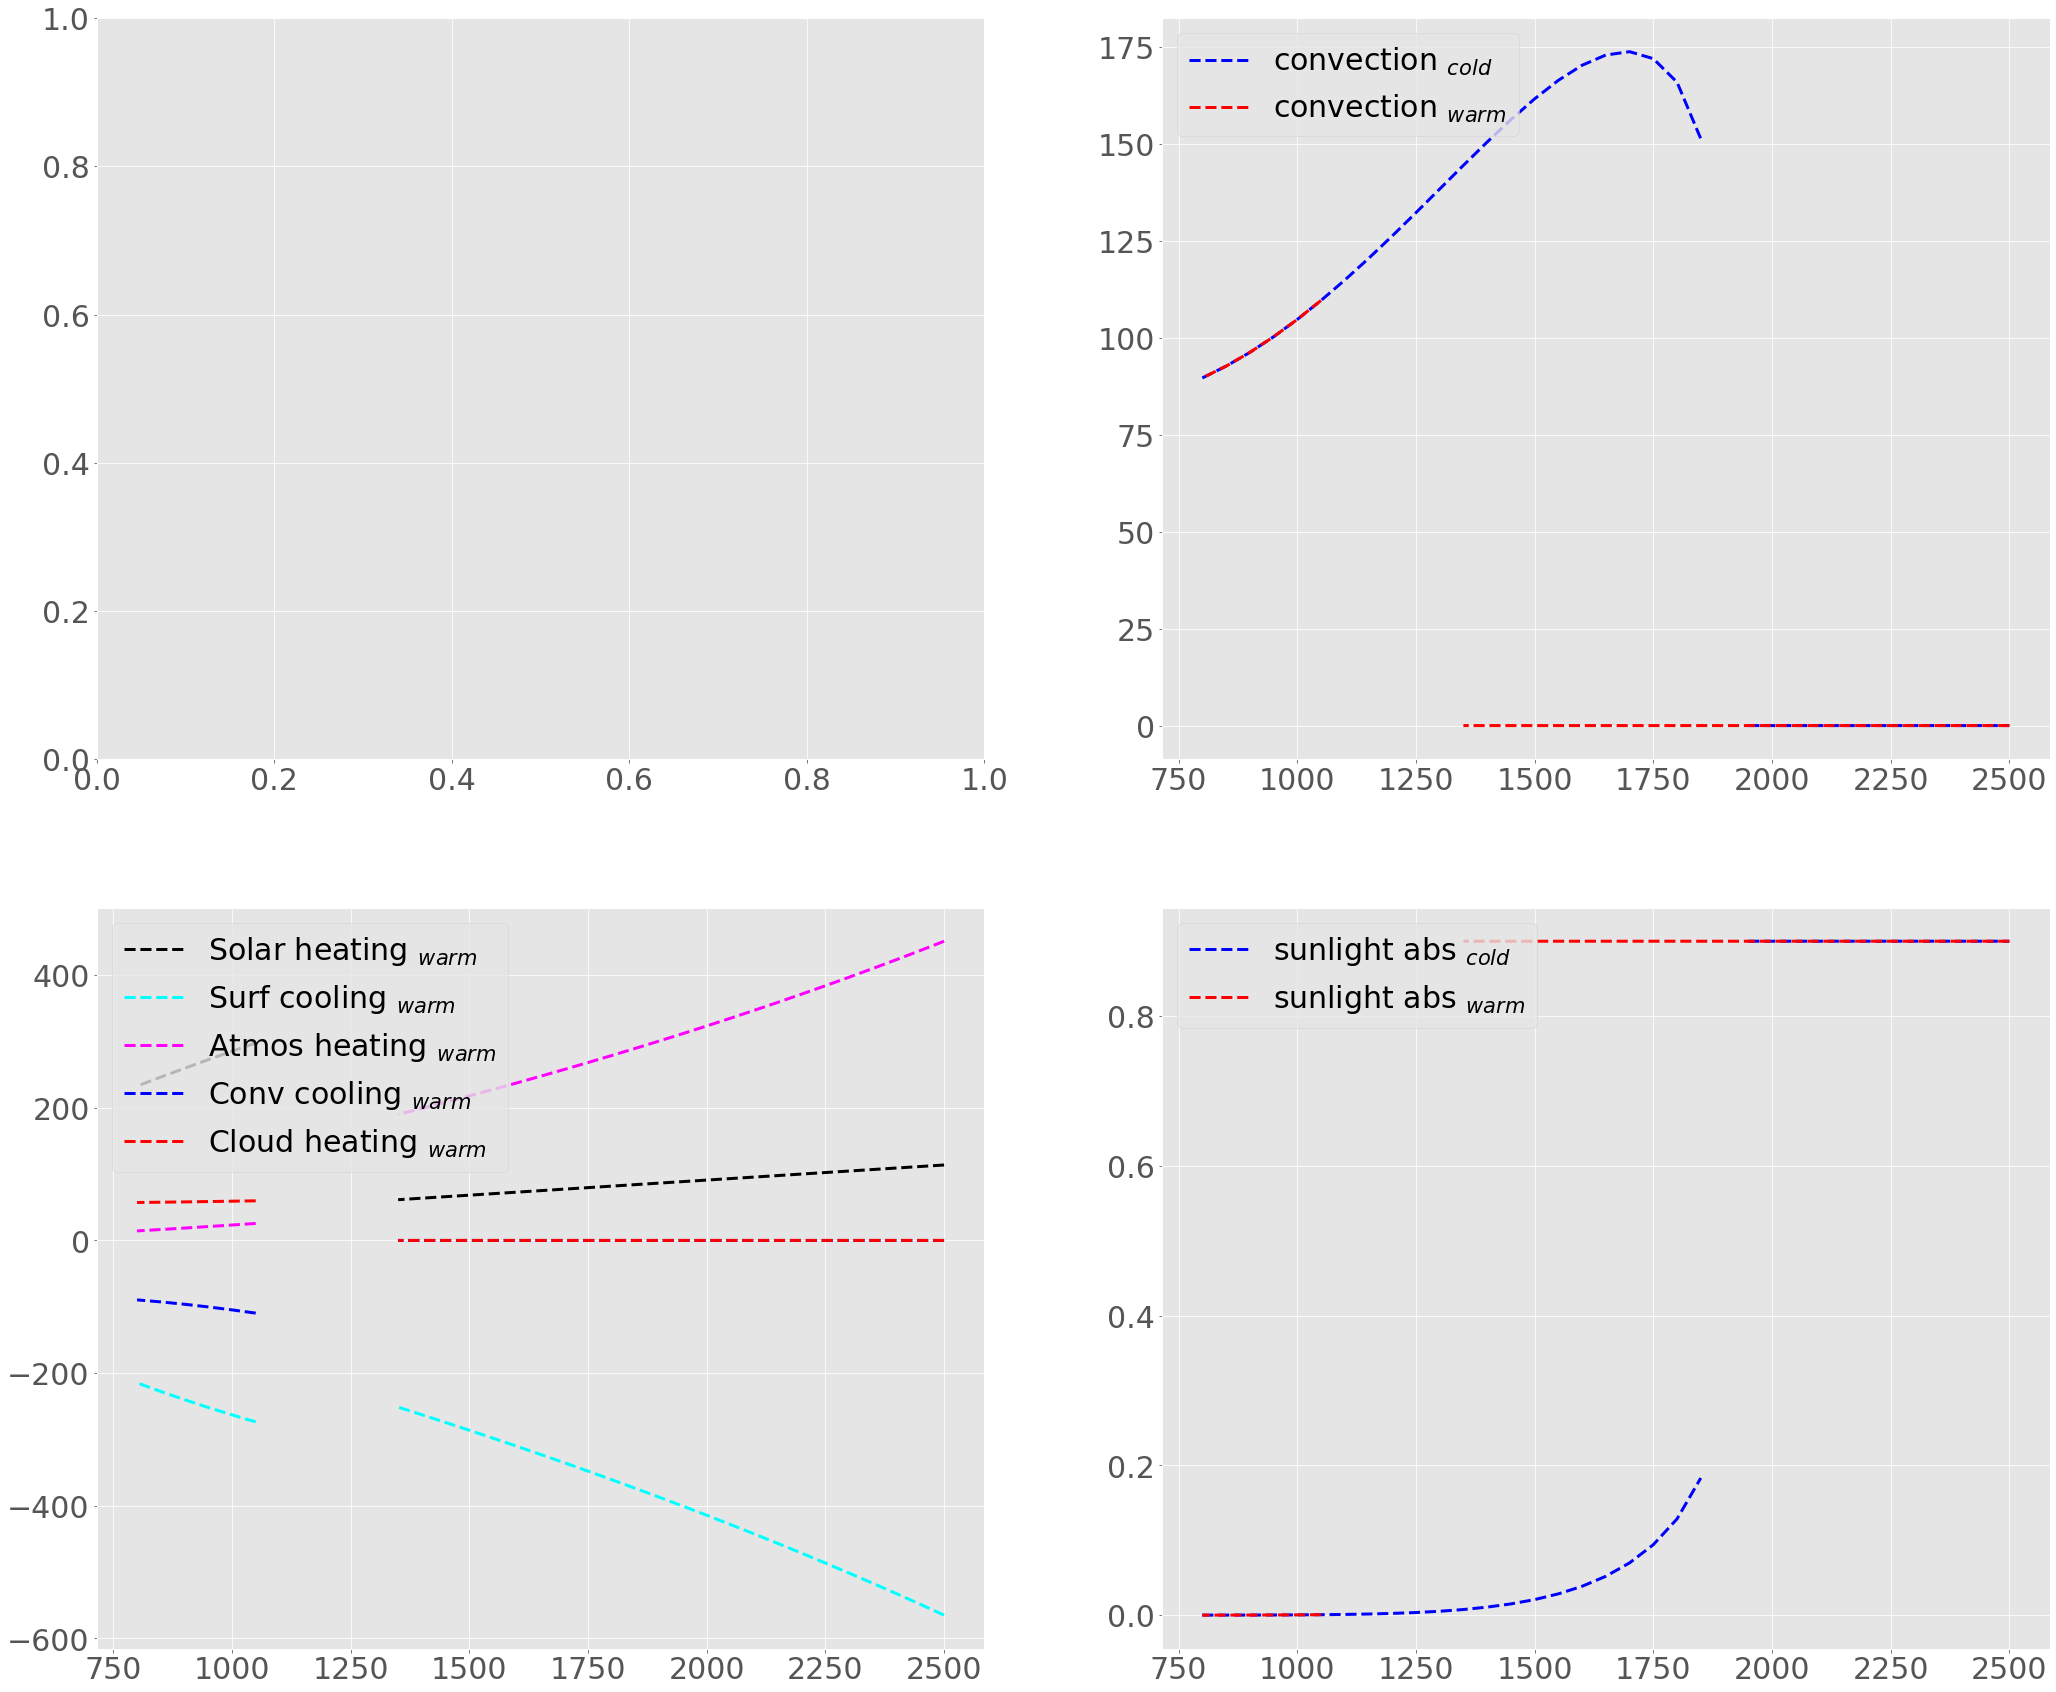

In [197]:
sigma = 5.67e-8
Tc = 230
a2_warm = np.array([d['a_2'] for d in warm_list])
a2_cold = np.array([d['a_2'] for d in cold_list])
Flux2_warm = np.array([d['Flux2'] for d in warm_list])
Fc_warm = np.array([d['Fc'] for d in warm_list])
Fc_cold = np.array([d['Fc'] for d in cold_list])

def plot_abs1(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,30)) 
    plt.rc('font', size = 30)
    ax[0,1].plot(np.flip(so), (Fc_cold),'--', color = 'blue',linewidth=3, label = r'convection $_{cold}$')
    ax[0,1].plot(so, (Fc_warm),'--', color = 'red',linewidth=3, label = r'convection $_{warm}$')
    ax[0,1].legend(loc = 2)
    
    ax[1,0].plot(so, so/2*(1-a2_warm)*(1-ap_warm),'--', color = 'black',linewidth=3, label = r'Solar heating $_{warm}$')
    ax[1,0].plot(so, -sigma*T1_warm**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{warm}$')
    ax[1,0].plot(so, (1-fc_warm)*Flux2_warm,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{warm}$')
    ax[1,0].plot(so, -Fc_warm,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{warm}$')
    ax[1,0].plot(so, fc_warm*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{warm}$')
    ax[1,0].legend(loc = 2)
    
    ax[1,1].plot(np.flip(so), (a2_cold),'--', color = 'blue',linewidth=3, label = r'sunlight abs $_{cold}$')
    ax[1,1].plot(so, (a2_warm),'--', color = 'red',linewidth=3, label = r'sunlight abs $_{warm}$')
    ax[1,1].legend(loc = 2)
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs1(so)

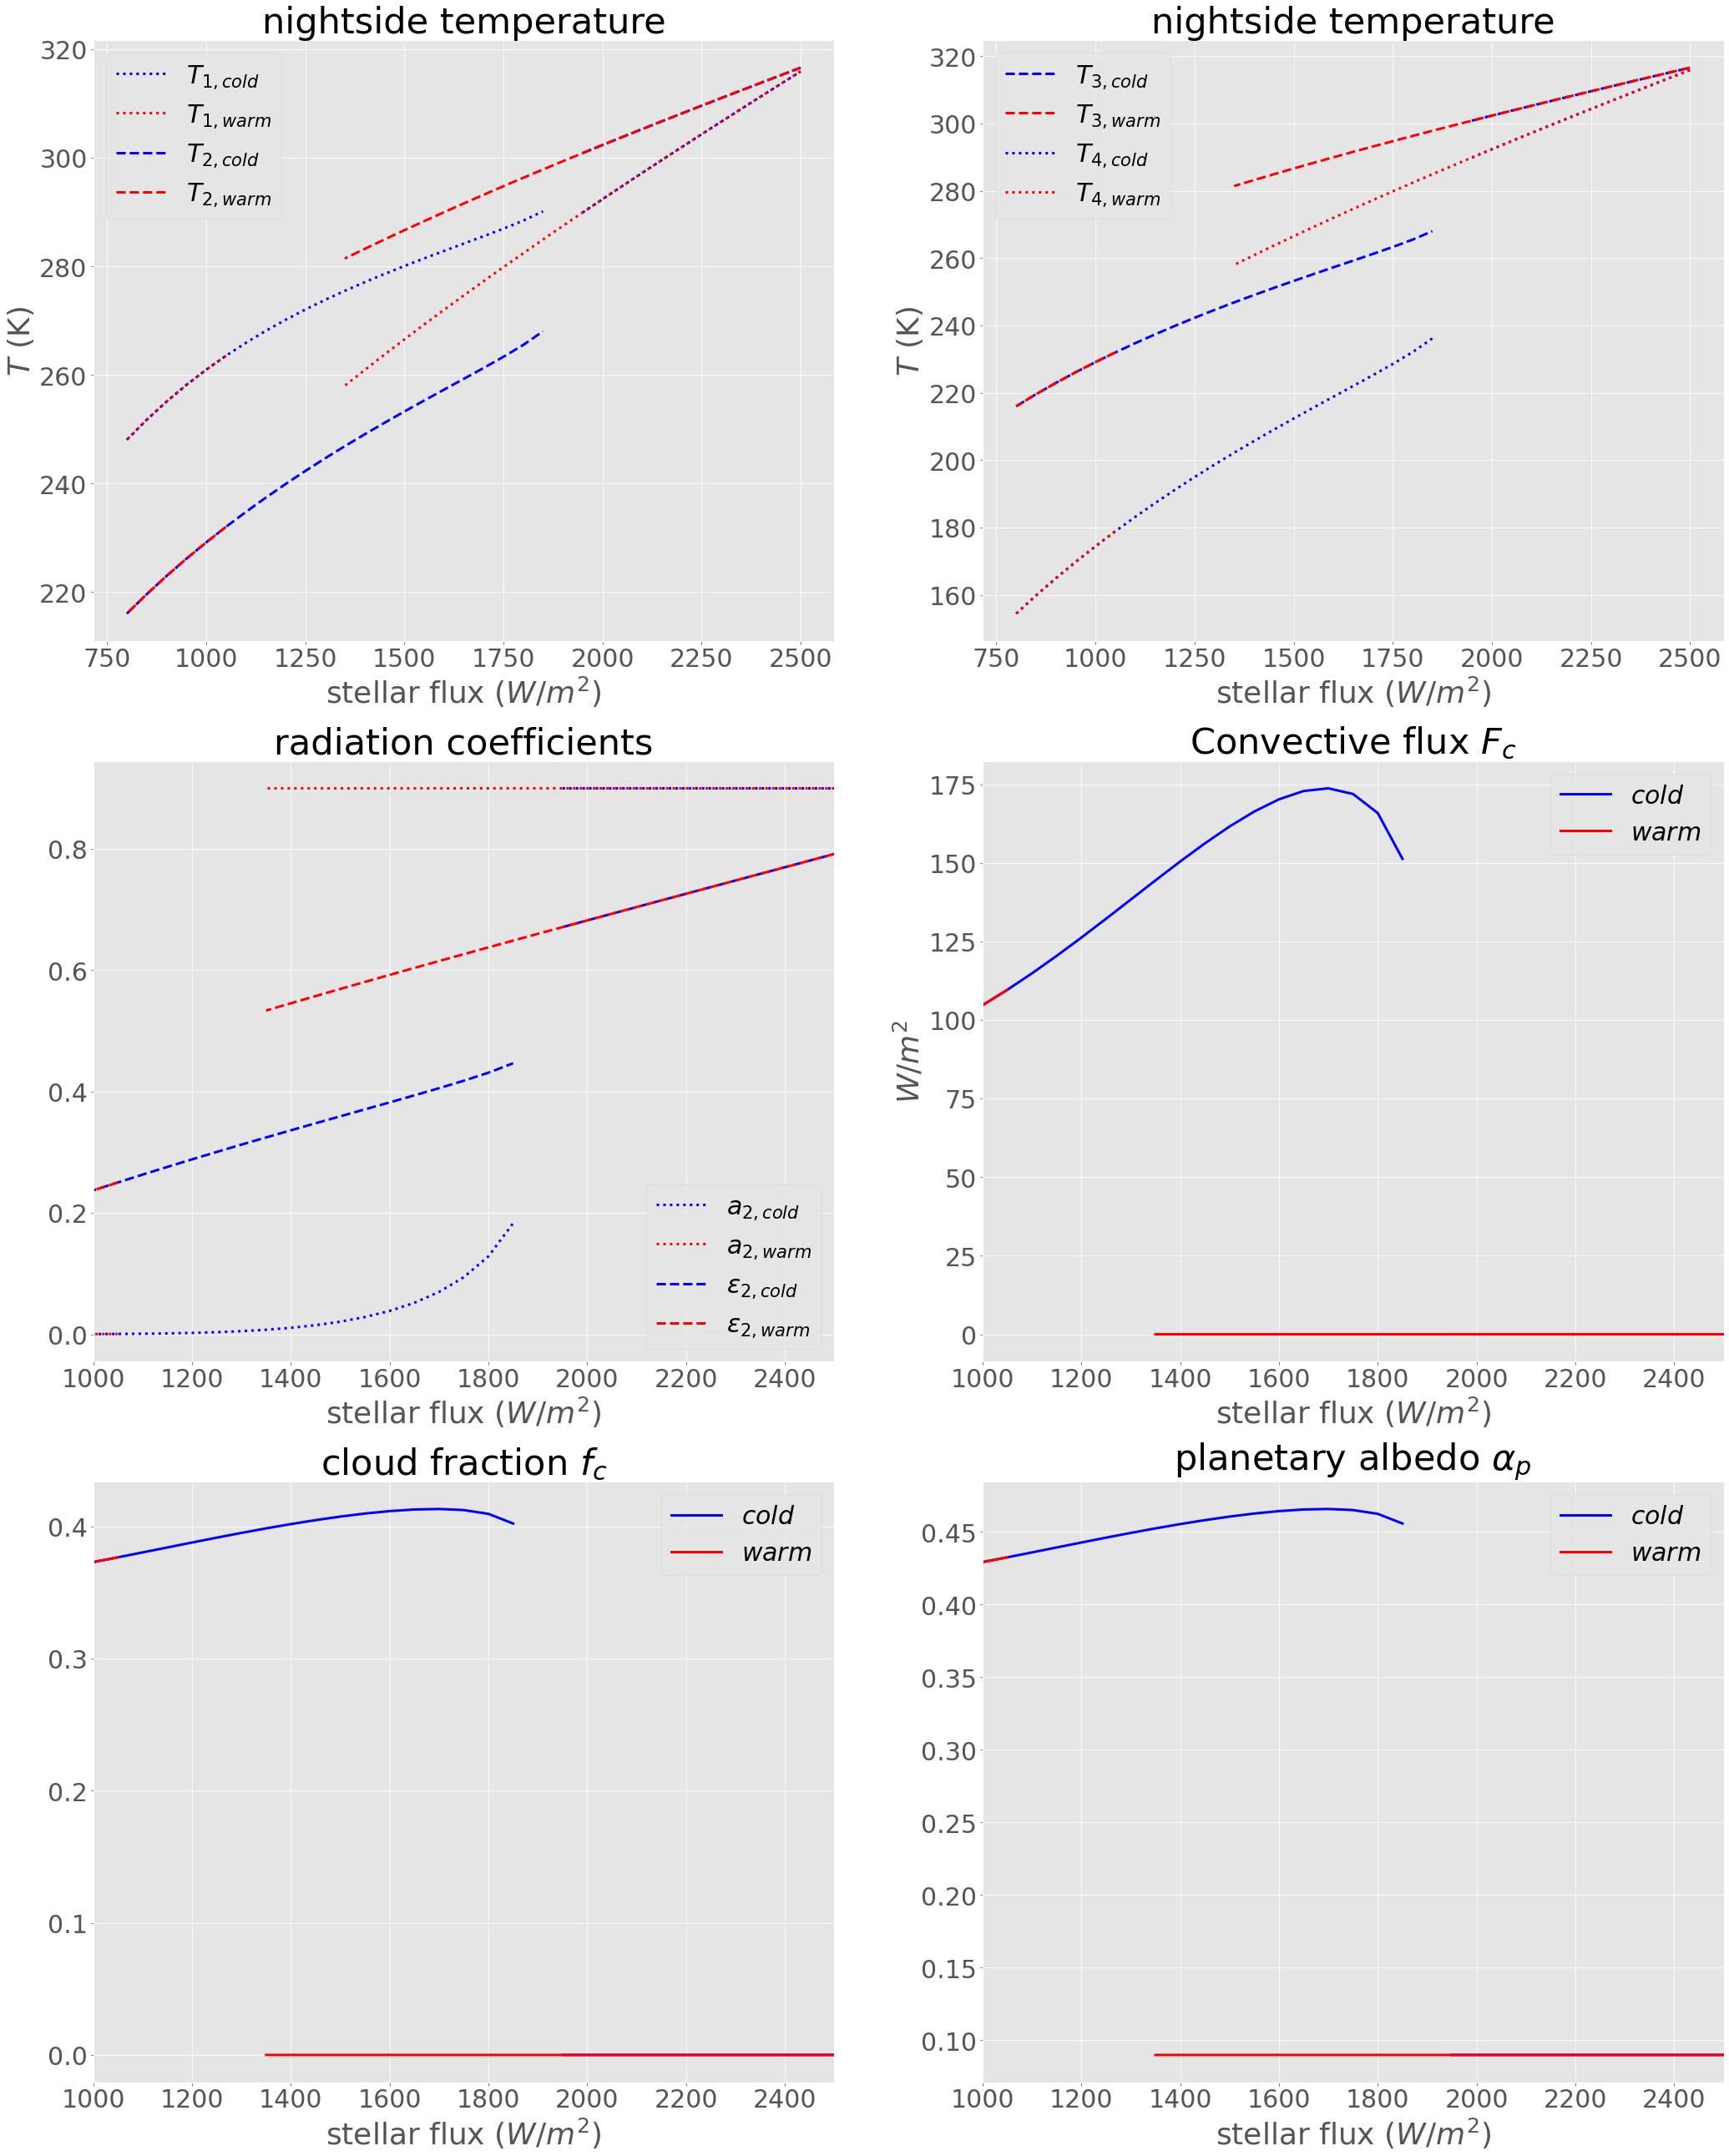

In [203]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(3, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_cold, ':', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[0,0].plot(so, T1_warm, ':', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[0,0].plot(np.flip(so), T2_cold, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[0,0].plot(so, T2_warm, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'nightside temperature')
    ax[0,0].legend()
    
#     # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T3_cold, '--', color = 'blue',linewidth=3, label = r'$T_{3, cold}$')
    ax[0,1].plot(so, T3_warm, '--', color = 'red', linewidth=3, label = r'$T_{3, warm}$')
    ax[0,1].plot(np.flip(so), T4_cold, ':', color = 'blue', linewidth=3, label = r'$T_{4, cold}$')
    ax[0,1].plot(so, T4_warm, ':', color = 'red',linewidth=3, label = r'$T_{4, warm}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'nightside temperature')
    ax[0,1].legend()

    #     # Dayside energy budgets
    ax[1,0].plot(np.flip(so), a2_cold,':', color = 'blue',linewidth=3, label = r'$a_{2, cold}$')
    ax[1,0].plot(so, a2_warm,':',color = 'red',linewidth=3, label = r'$a_{2, warm}$')
    ax[1,0].plot(np.flip(so), e2_cold,'--', color = 'blue',linewidth=3, label = r'$\epsilon_{2, cold}$')
    ax[1,0].plot(so, e2_warm,'--',color = 'red',linewidth=3, label = r'$\epsilon_{2, warm}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_title('radiation coefficients')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
#     # Dayside energy budgets
    ax[1,1].plot(np.flip(so), Fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[1,1].plot(so, Fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_title(r'Convective flux $F_c$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].legend()
    
    #     # Dayside energy budgets
    ax[2,0].plot(np.flip(so), fc_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[2,0].plot(so, fc_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[2,0].set_xlim([1000, 2500])
    ax[2,0].set_title(r'cloud fraction $f_c$')
    ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,0].legend()
    
#     # Dayside energy budgets
    ax[2,1].plot(np.flip(so), ap_cold,'-', color = 'blue',linewidth=3, label = r'${cold}$')
    ax[2,1].plot(so, ap_warm,'-',color = 'red',linewidth=3, label = r'${warm}$')
    ax[2,1].set_xlim([1000, 2500])
    ax[2,1].set_title(r'planetary albedo $\alpha_p$')
    ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [9]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_brrr, T2_brrr, T3_brrr, T4_brrr, Fa_brrr, Fc_brrr, fc_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brrr, q2_brrr, q3_brrr, alpha_p_brrr, epsilon_2_brrr, epsilon_3_brrr, OLR1_brrr, OLR2_brrr, Flux1_brrr, Flux2_brrr, Flux3_brrr, Flux4_brrr, FluxC_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,200,200,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx], fc_brrr[idx], \
        q1_brrr[idx],q2_brrr[idx],q3_brrr[idx],alpha_p_brrr[idx],epsilon_2_brrr[idx],epsilon_3_brrr[idx], \
        OLR1_brrr[idx], OLR2_brrr[idx], Flux1_brrr[idx], Flux2_brrr[idx], Flux3_brrr[idx], Flux4_brrr[idx], FluxC_brrr[idx], info,ier,msg = solar_abs_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution:  (282.21315000066875, 256.3633243285355, 256.3633243285355, 222.2749409838954, 182.7011790699473, -127.70554027494097)
1 1100.0
We have a solution:  (285.02293429070187, 260.4883474043525, 260.4883474043525, 238.29159313980216, 224.17169522480614, -98.32630194998643)
2 1200.0
We have a solution:  (287.7680993195153, 264.5444337347483, 264.5444337347483, 252.73645885007238, 261.2397859384492, -74.16444635448123)
3 1300.0
We have a solution:  (290.65926707314543, 268.79358172180446, 268.79358172180446, 266.03349862839303, 293.12220813149736, -56.09524023535749)
4 1400.0
We have a solution:  (293.84995753723643, 273.40152096754827, 273.40152096754827, 277.99123287642396, 319.70191245957795, -43.73660884314195)
5 1500.0
We have a solution:  (297.2986904352026, 278.2371403319143, 278.2371403319143, 287.76572786574803, 342.63168145661837, -35.057938091340134)
6 1600.0
We have a solution:  (300.78071678595154, 282.93860344734844, 282.93860344734844, 294.9992683805

In [75]:
# check the role of atmospheric circulation (Fa = 0)

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_circ_func(So=1360, Fo=0, a_2 = 0.5, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, Fc = p 
#         T1, T2, T3, T4, Fa, Fc = p     
        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
#         RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
#         # water vapor calculations for nightside atmosphere
#         es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
#         ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
#         w_3 = RH3 * ws_3
#         q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
#         k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
        k2 = 10
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
#         a_2 = 0.9 # water vapor absorption to sunlight
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a_2) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

#         Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

#         Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
#         Eq6_WTG = T2 - T3      # weak temperature gradient assumption

#         Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
#         Flux3 = epsilon_3*sigma*T3**4
#         Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
#             Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
#             Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq7)
#             return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2)
#             return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#     (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution w/ conv.: ', (T1, T2, Fc))
        Es = T1**4
        Ea = T2**4 
        print('The average atmosphere-surface energy ratio is:', (Ea/Es))
        if Fc <= 0:
            print('Yet the solution is incorrect, solve without convection')
    
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,alpha_p,epsilon_2,OLR_day, Flux1, Flux2 = equations((T1, T2, Fc))
#     fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC, info,ier,msg)
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [76]:
# check the role of atmospheric circulation (Fa = 0)

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_circ_func_ver2(So=1360, Fo=0, a_2 = 0.5, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250), debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2 = p 
#         T1, T2, T3, T4, Fa, Fc = p     
        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
#         RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
#         # water vapor calculations for nightside atmosphere
#         es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
#         ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
#         w_3 = RH3 * ws_3
#         q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
#         k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
        k2 = 10
    
        Fd = 0
        Fc = 0
        fc = 0
#         if Fc + 1.0 <= 0:
# #             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
#             fc = 0
#         else:
#             fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
#             if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#                 print("Cloud fraction too high, corrected as 1")
#                 fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
#         a_2 = 0.9 # water vapor absorption to sunlight
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a_2) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

#         Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

#         Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
#         Eq6_WTG = T2 - T3      # weak temperature gradient assumption

#         Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

#         Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
#         # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
#         Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
#         Flux3 = epsilon_3*sigma*T3**4
#         Flux4 = (1-epsilon_3)*sigma*T3**4
        
#         if assumption == 'WTG':                         
# #             Eq6 = Eq6_WTG
#             Eq7 = Eq7_WTG                       
#         elif assumption == 'WBG':
# #             Eq6  = Eq6_WBG
#             Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3)
#             return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2)
#             return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#     (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution w/o conv.: ', (T1, T2))
        Es = T1**4
        Ea = T2**4 
        print('The average atmosphere-surface energy ratio is:', (Ea/Es))
        print('\n')
    
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,alpha_p,epsilon_2,OLR_day, Flux1, Flux2 = equations((T1, T2))
#     fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC, info,ier,msg)
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [80]:
# Example debug mode
S = 1200       # W/m2
T1_init = 328  # K
T2_init = 314  # K
Fc_init = 318  # W/m2

no_circ_func(So=S, a_2 = 0.9, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, Fc_init))


We have a solution w/ conv.:  (317.67972456437906, 303.3723044127005, -367.33619169740354)
The average atmosphere-surface energy ratio is: 0.8316598428431469
Yet the solution is incorrect, solve without convection


(317.67972456437906,
 303.3723044127005,
 -367.33619169740354,
 0,
 0.058763208069445086,
 0.039138144173929974,
 0.09,
 0.3238777943842016,
 545.9999999999029,
 390.45073839665696,
 155.54926160324595,
 -0.0,
 {'nfev': 16,
  'fjac': array([[-3.63306552e-04,  1.95276329e-04,  9.99999915e-01],
         [-5.41009874e-01,  8.41016163e-01, -3.60783012e-04],
         [ 8.41016162e-01,  5.41009959e-01,  1.99900261e-04]]),
  'r': array([ 1.79462226e+04, -1.22700515e+04,  8.97795666e-04, -1.01581809e+01,
          1.42394392e+00, -3.27847618e-01]),
  'qtf': array([ 2.63965902e-06, -6.61436536e-10,  8.97294234e-10]),
  'fvec': array([2.54658516e-11, 7.15090209e-11, 4.27186023e-07])},
 1,
 'The solution converged.')

In [83]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, alpha_p_crr, epsilon_2_crr, OLR1_crr, Flux1_crr, Flux2_crr, FluxC_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
# initial_guess = (250,250,20)
# initial_guess2 = (250,250)
initial_guess = (328,314,318)
initial_guess2 = (328,314)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], Fc_crr[idx], fc_crr[idx], \
        q1_crr[idx],q2_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx], \
        OLR1_crr[idx], Flux1_crr[idx], Flux2_crr[idx], FluxC_crr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.5, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if Fc_crr[idx] <= 0:
        Fc_crr[idx] = 0
        T1_crr[idx], T2_crr[idx], fc_crr[idx], \
            q1_crr[idx],q2_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx], \
            OLR1_crr[idx], Flux1_crr[idx], Flux2_crr[idx], FluxC_crr[idx], info,ier,msg = no_circ_func_ver2(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess2, debug=True)
        
    initial_guess = (T1_crr[idx], T2_crr[idx], Fc_crr[idx])
    initial_guess2 = (T1_crr[idx], T2_crr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution w/ conv.:  (300.9613869469417, 283.1774049102892, -200.7650063635986)
The average atmosphere-surface energy ratio is: 0.7837747559886062
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (278.5098666364168, 314.511529380133)
The average atmosphere-surface energy ratio is: 1.6262373844798395


1 1100.0
We have a solution w/ conv.:  (309.3486891376933, 293.73506019890726, -187.54462805486443)
The average atmosphere-surface energy ratio is: 0.8128867183960744
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (288.2437357405411, 317.37298146392476)
The average atmosphere-surface energy ratio is: 1.4697392617806238


2 1200.0
We have a solution w/ conv.:  (317.6797245644966, 303.37230441350425, -148.936191692733)
The average atmosphere-surface energy ratio is: 0.8316598428507296
Yet the solution is incorrect, solve without convection
We have a solution w/o conv.:  (298.0429828815528, 320.37

In [56]:
print(epsilon_2_crr)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crrr, T2_crrr, Fc_crrr, fc_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crrr, q2_crrr, alpha_p_crrr, epsilon_2_crrr, OLR1_crrr, Flux1_crrr, Flux2_crrr, FluxC_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx], fc_crrr[idx], \
        q1_crrr[idx],q2_crrr[idx],alpha_p_crrr[idx],epsilon_2_crrr[idx], \
        OLR1_crrr[idx], Flux1_crrr[idx], Flux2_crrr[idx], FluxC_crrr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution:  (314.0856747961571, 299.30025333727974, -51.2922226807497)
1 1100.0
We have a solution:  (320.5227542158111, 306.5174865894208, -47.88711778755008)
2 1200.0
We have a solution:  (326.78574988630237, 313.2581623719902, -45.99970039300991)
3 1300.0
We have a solution:  (332.8383884891894, 319.58980925206725, -45.20171410179556)
4 1400.0
We have a solution:  (338.65945950512815, 325.56603723657065, -45.12322387512406)
5 1500.0
We have a solution:  (344.2397626806751, 331.23017893021455, -45.45920391790805)
6 1600.0
We have a solution:  (349.5782403231305, 336.61780218465765, -45.96056998700432)
7 1700.0
We have a solution:  (354.6789870340499, 341.75849207171865, -46.423614022609506)
8 1800.0
We have a solution:  (359.549432441618, 346.6771444951557, -46.68349825118107)
9 1900.0
We have a solution:  (364.19968765841435, 351.3949247948506, -46.6153022327873)
10 2000.0
We have a solution:  (368.64337650460385, 355.92999079029073, -46.14976566776978)
11 2100.0
W

<ipython-input-10-727aa763cdcc>:94: RuntimeWarning: overflow encountered in exp
  epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
<ipython-input-10-727aa763cdcc>:103: RuntimeWarning: invalid value encountered in double_scalars
  Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4
<ipython-input-10-727aa763cdcc>:118: RuntimeWarning: invalid value encountered in double_scalars
  OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4


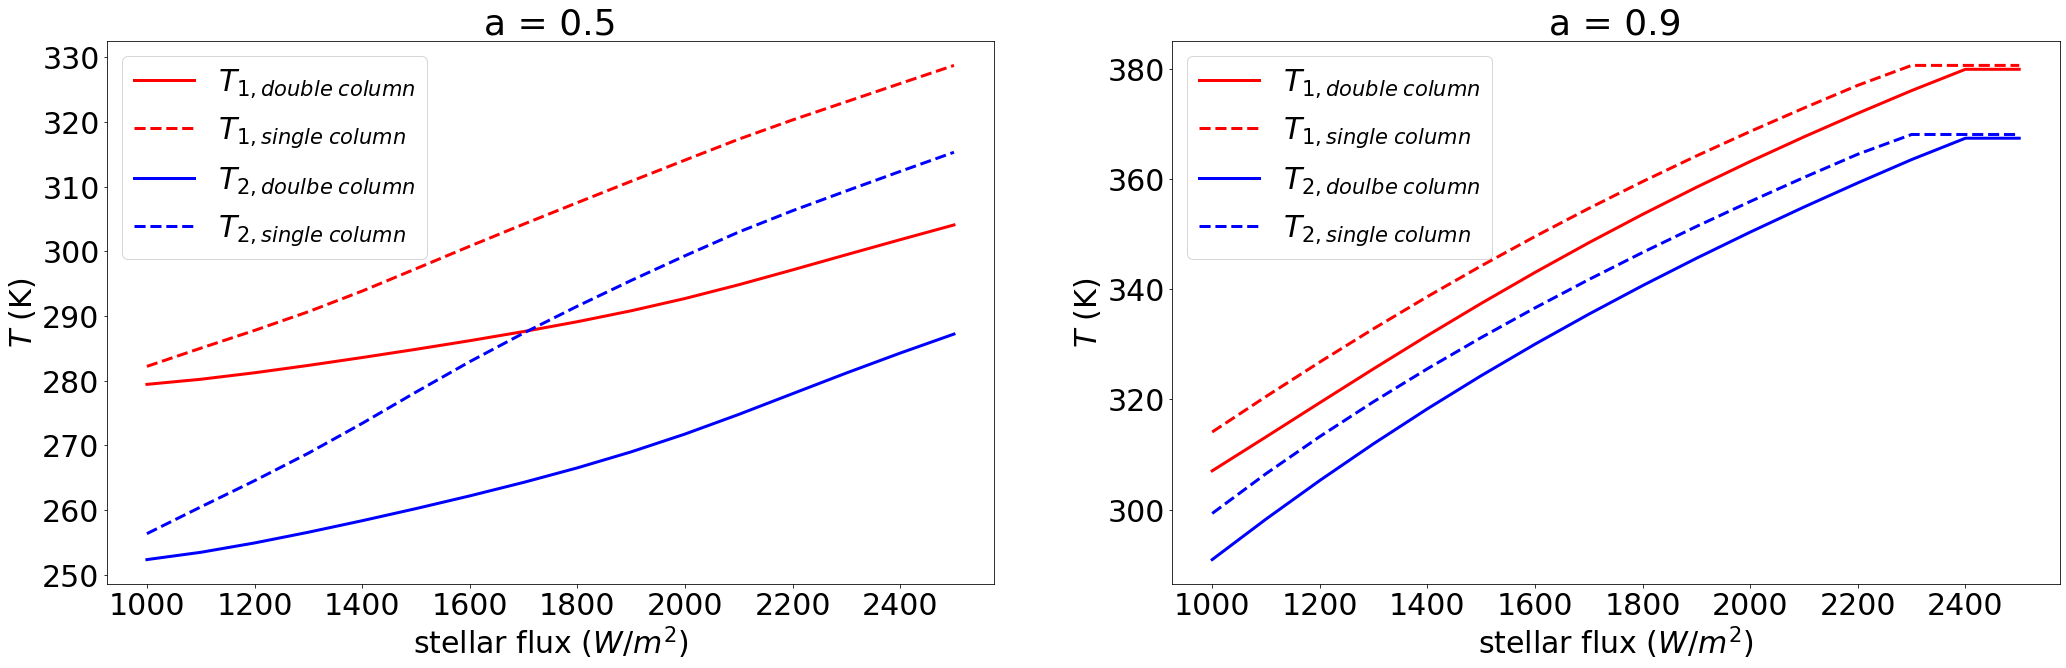

In [19]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 2, figsize=(35,10)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[0].plot(so, T1_brrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[0].plot(so, T2_brrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[0].set_ylabel(r'$T$ (K)')
    ax[0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0].set_title(r'a = 0.5')
    ax[0].legend()
    
    # Nightside temperature structure
    ax[1].plot(so, T1_crr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[1].plot(so, T1_crrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[1].plot(so, T2_crr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[1].plot(so, T2_crrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[1].set_ylabel(r'$T$ (K)')
    ax[1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1].set_title(r'a = 0.9')
    ax[1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

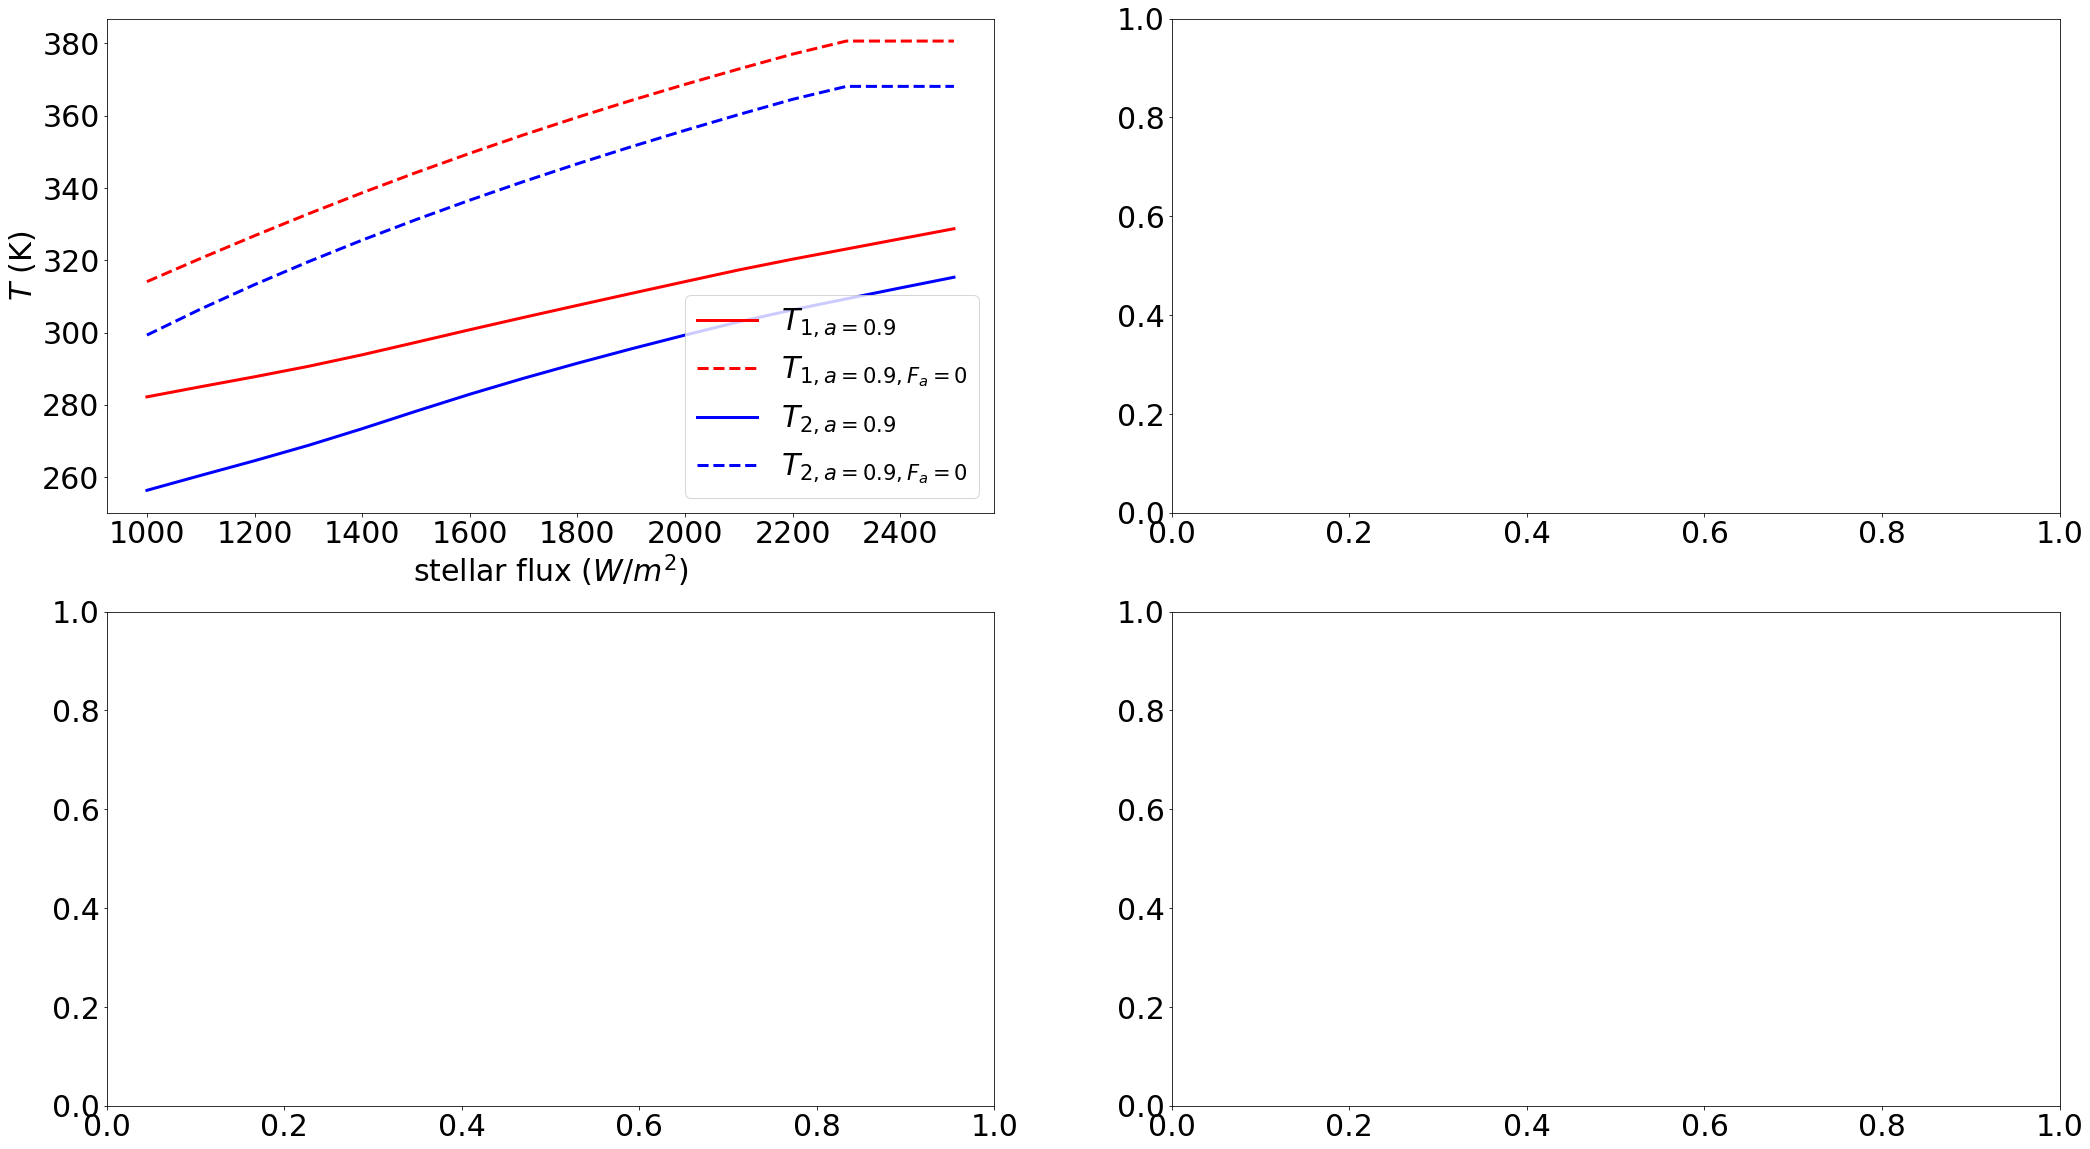

In [25]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T1_crr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9, F_a = 0}$')
    ax[0,0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].plot(so, T2_crr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9, F_a = 0}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
#     # Nightside temperature structure
#     ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
#     ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
#     ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
#     ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
#     ax[0,1].set_ylabel(r'$T$ (K)')
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,1].legend()
    
#     # Dayside energy budgets
#     ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
#     ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
#     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_ylabel(r'$W/m^2$')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].legend()
    
#     # Nightside energy budgets
#     ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
#     ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
#     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_ylabel(r'$W/m^2$')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [72]:
print("Check variables")
print("T1 = {} K".format(round(T1_brr[0],2)))
print("T2 = {} K".format(round(T2_brr[0],2)))
print("T3 = {} K".format(round(T3_brr[0],2)))
print("T4 = {} K".format(round(T4_brr[0],2)))
print("F_a = {} W/m2".format(round(Fa_brr[0],2)))
print("F_c = {} W/m2".format(round(Fc_brr[0],2)))
print("dayside cloud fraction = {}".format(round(fc_brr[0],2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1_brr[0],4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2_brr[0],4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3_brr[0],6)))
print("planetary albedo = {}".format(round(alpha_p_brr[0],3)))
print("dayside emissivity = {}".format(round(epsilon_2_brr[0],3)))
print("nightside emissivity = {}".format(round(epsilon_3_brr[0],3)))
print("dayside OLR = {} W/m2".format(round(OLR1_brr[0],1)))
print("nightside OLR = {} W/m2".format(round(OLR2_brr[0],1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1_brr[0],1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2_brr[0],1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC_brr[0],1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3_brr[0],1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4_brr[0],1)))

Check variables
T1 = 279.43 K
T2 = 252.35 K
T3 = 252.35 K
T4 = 205.9 K
F_a = 142.75 W/m2
F_c = 3.43 W/m2
dayside cloud fraction = 0.12
dayside surface specific humidity = 0.0055 kg/kg
dayside atmos specific humidity = 0.001 kg/kg
nightside atmos specific humidity = 0.000384 kg/kg
planetary albedo = 0.198
dayside emissivity = 0.641
nightside emissivity = 0.319
dayside OLR = 258.1 W/m2
nightside OLR = 142.8 W/m2
dayside surface cooling = 124.2 W/m2
dayside atmospheric cooling = 147.4 W/m2
dayside cloud radiative effect = -52.0 W/m2
nightside surface cooling = 73.4 W/m2
nightside atmospheric cooling = 156.6 W/m2


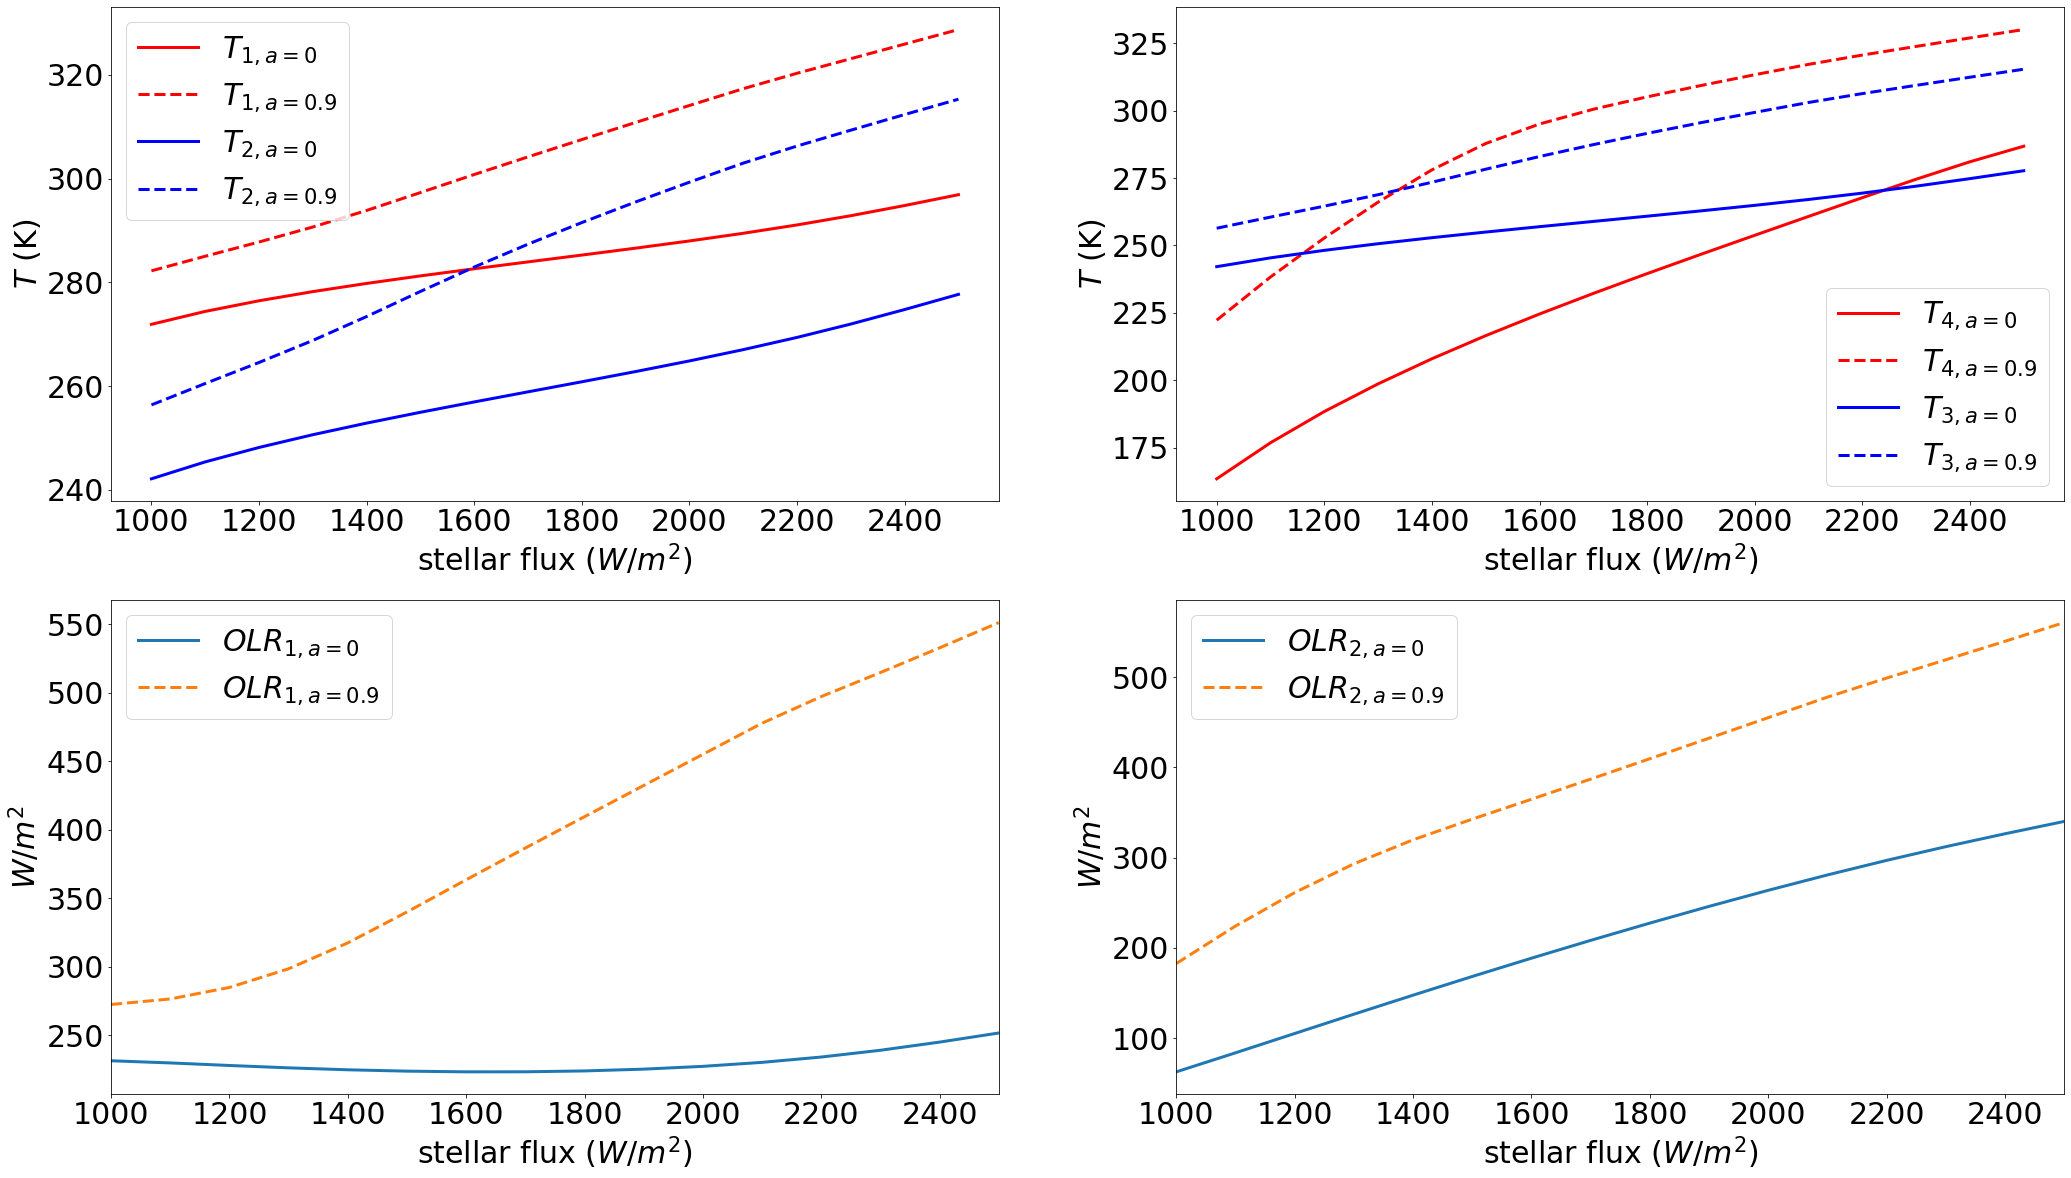

In [121]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_brr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_brr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
    ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

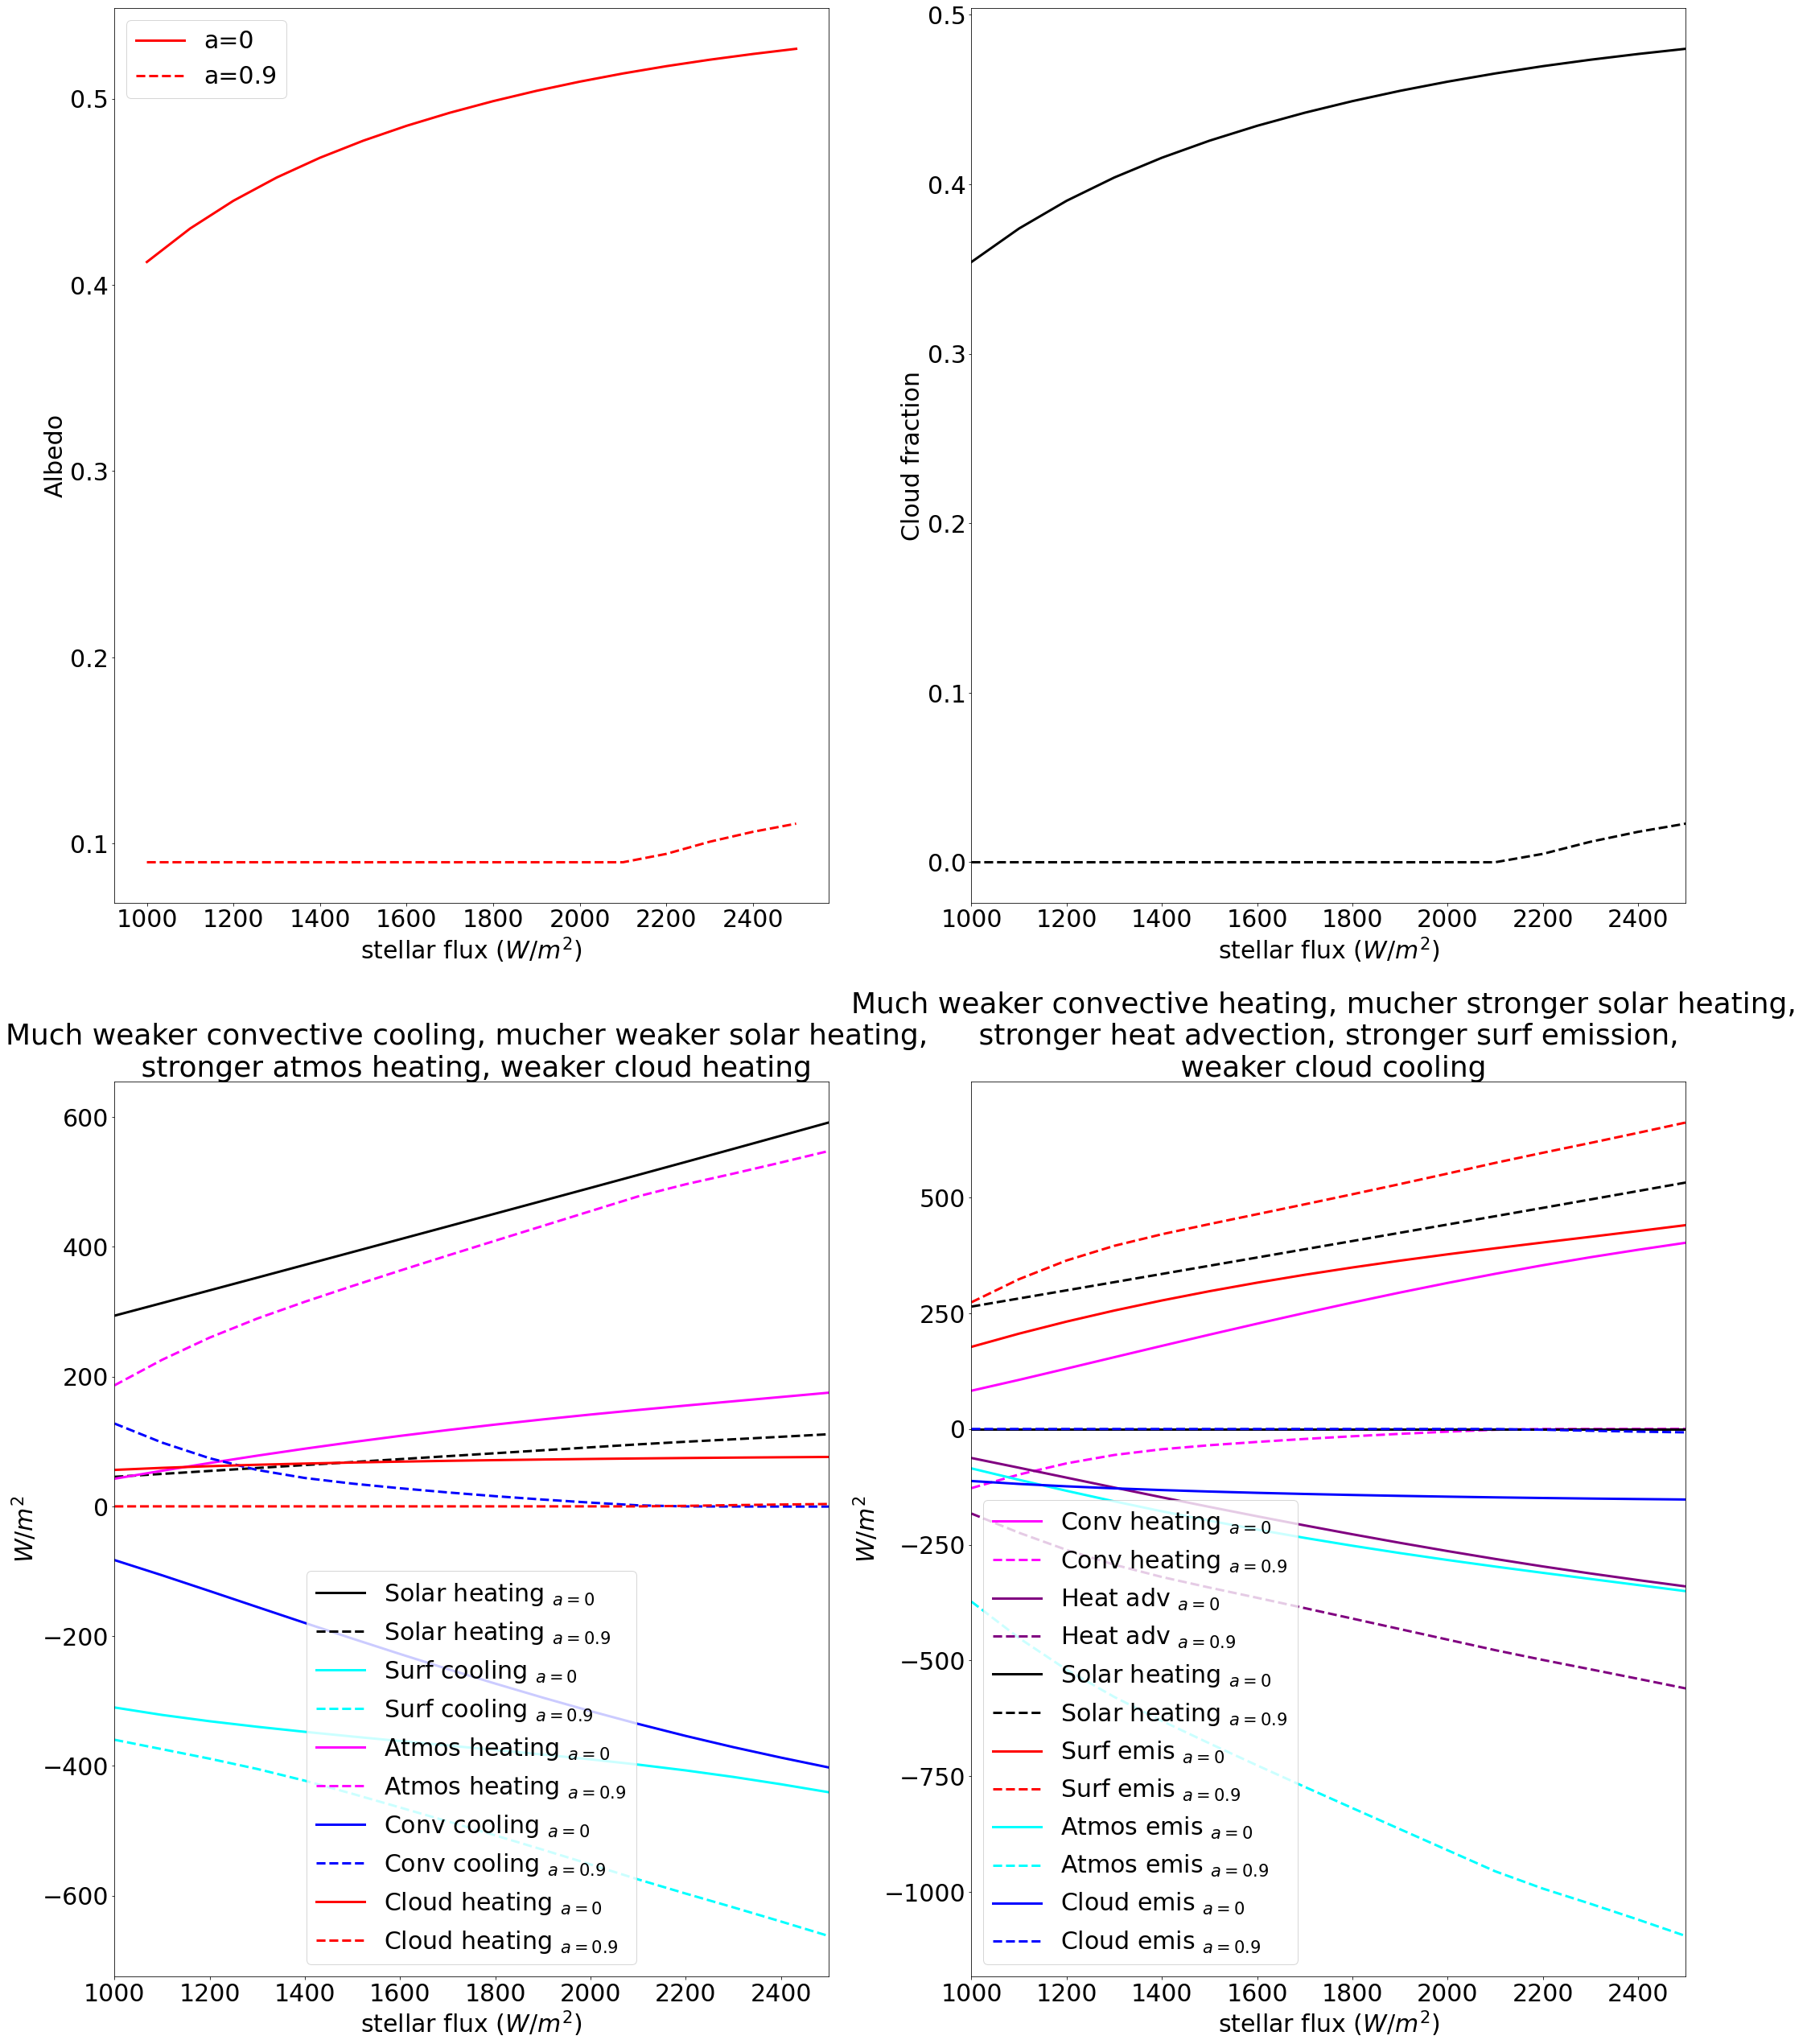

In [124]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.9
    
    fig, ax = plt.subplots(2, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, alpha_p_arr, '-', color = 'red',linewidth=3, label = "a=0")
    ax[0,0].plot(so, alpha_p_brr, '--', color = 'red', linewidth=3, label = "a=0.9")
    ax[0,0].set_ylabel("Albedo")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Dayside emmisivity
    ax[0,1].plot(so, fc_arr,'-', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0}$')
    ax[0,1].plot(so, fc_brr,'--', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0.9}$')
    ax[0,1].set_xlim([1000, 2500])
    ax[0,1].set_ylabel("Cloud fraction")
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Dayside energy budgets
    ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,0].plot(so, -sigma*T1_arr**4,'-', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0}$')
    ax[1,0].plot(so, -sigma*T1_brr**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0.9}$')
    ax[1,0].plot(so, (1-fc_arr)*Flux2_arr,'-', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0}$')
    ax[1,0].plot(so, (1-fc_brr)*Flux2_brr,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0.9}$')
    ax[1,0].plot(so, -Fc_arr,'-', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0}$')
    ax[1,0].plot(so, -Fc_brr,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0.9}$')
    ax[1,0].plot(so, fc_arr*sigma*Tc**4,'-', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0}$')
    ax[1,0].plot(so, fc_brr*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0.9}$')  
    
#     ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr) + fc_arr*sigma*Tc**4 - sigma*T1_arr**4 + (1-fc_arr)*Flux2_arr - Fc_arr,'-', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0}$')
#     ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr) + fc_brr*sigma*Tc**4 - sigma*T1_brr**4 + (1-fc_brr)*Flux2_brr - Fc_brr,'--', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    ax[1,0].set_title("Much weaker convective cooling, mucher weaker solar heating, \n stronger atmos heating, weaker cloud heating")
    
    # Nightside energy budgets
    ax[1,1].plot(so, Fc_arr,'-', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0}$')
    ax[1,1].plot(so, Fc_brr,'--', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0.9}$')
    ax[1,1].plot(so, -Fa_arr,'-', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0}$')
    ax[1,1].plot(so, -Fa_brr,'--', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0.9}$')
    ax[1,1].plot(so, so/2*(1-1)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,1].plot(so, so/2*a*(1-alpha_p_arr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,1].plot(so, ((1-fc_arr)*epsilon_2_arr+fc_arr)*sigma*T1_arr**4,'-', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0}$')
    ax[1,1].plot(so, ((1-fc_brr)*epsilon_2_brr+fc_brr)*sigma*T1_brr**4,'--', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*(1-fc_arr)*epsilon_2_arr*sigma*T2_arr**4,'-', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0}$')
    ax[1,1].plot(so, -2*(1-fc_brr)*epsilon_2_brr*sigma*T2_brr**4,'--', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*fc_arr*sigma*Tc**4,'-', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0}$')
    ax[1,1].plot(so, -2*fc_brr*sigma*Tc**4,'--', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    ax[1,1].set_title("Much weaker convective heating, mucher stronger solar heating, \n stronger heat advection, stronger surf emission, \n weaker cloud cooling")
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

Text(0.5, 1.0, 'my idealized SW/LW ratio')

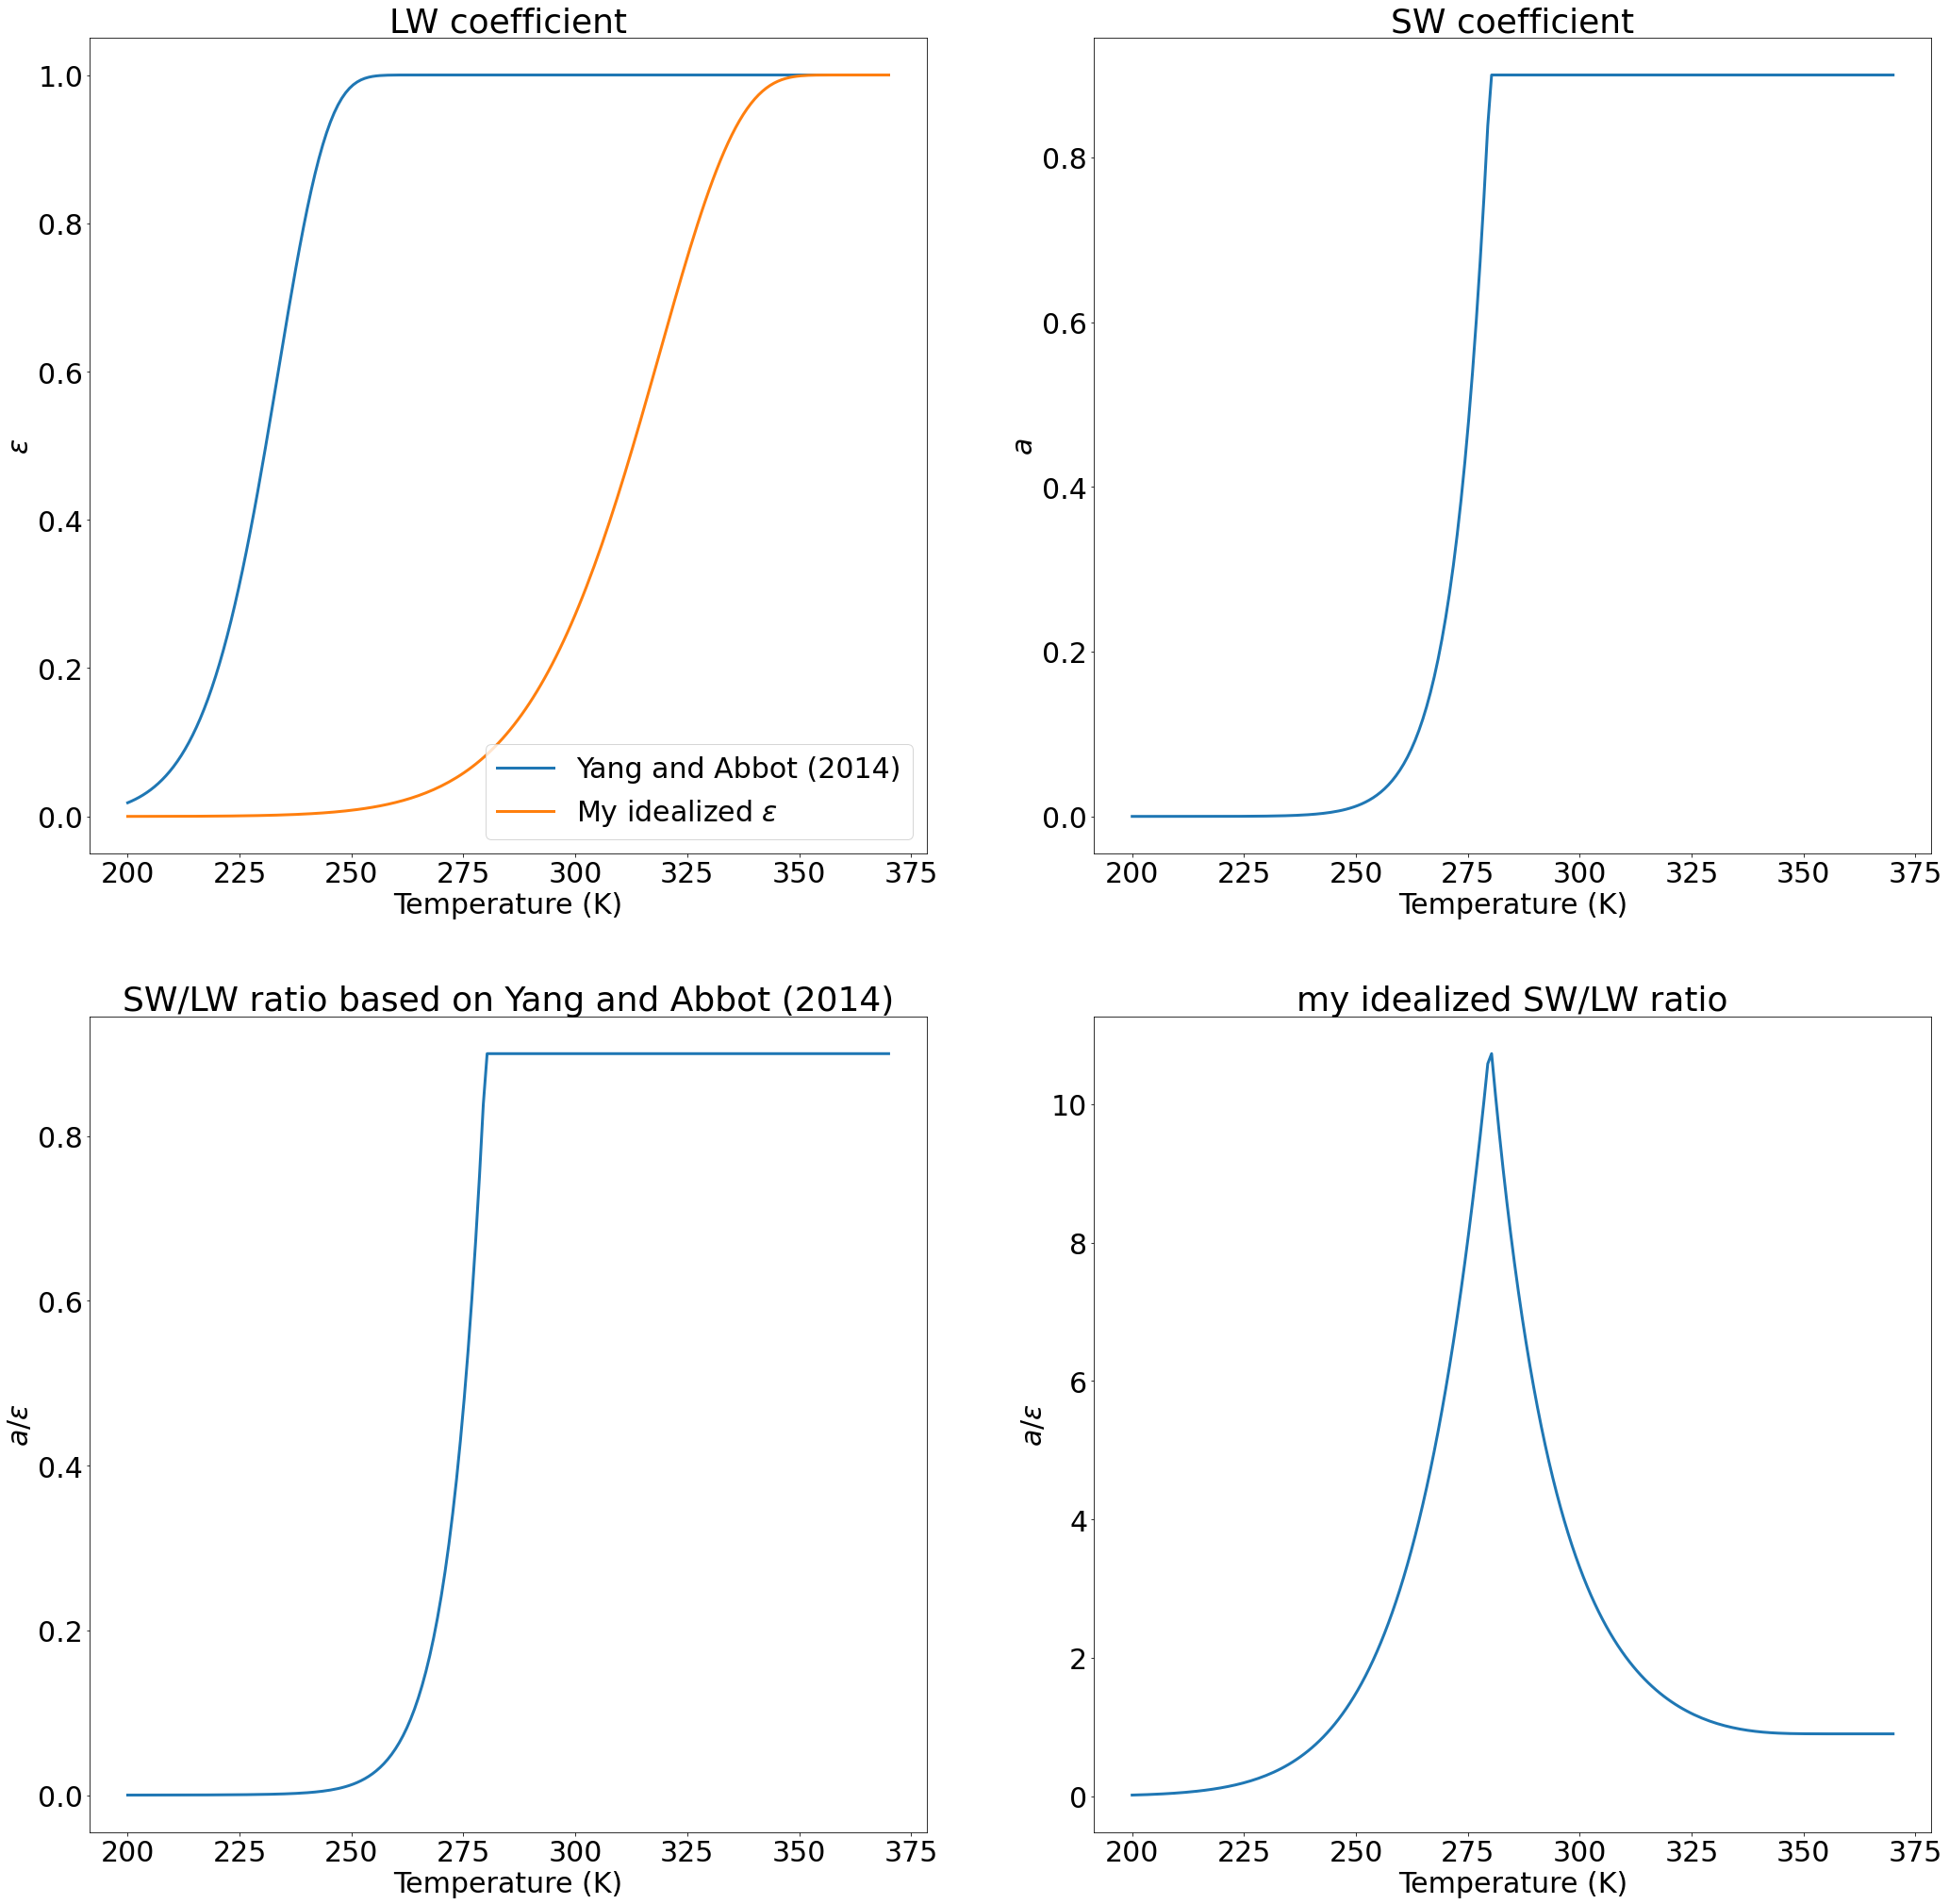

In [11]:
def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau


def epsilon_orig(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
#     k2 = 1e4
    k2 = 5000
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2

def epsilon_orig_ver2(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
#     k2 = 1e4
    k2 = 10
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2  

# def a(T):
#     T_ref = 280   # Temperature of full absorption limit 
#     a_ref = 0.9      # Max water vapor absorption to sunlight
#     ka = 10e3      # exponetional factor (like CC relation)
#     if T <= T_ref:
#         a_2 = a_ref*np.exp(-ka*(1/T - 1/T_ref))
#     else:
#         a_2 = a_ref
#     return a_2

def water_vapor_absorption(temperature):
    temperature_ref = 280   # Temperature of full absorption limit 
    absorption_ref = 0.9      # Max water vapor absorption to sunlight
    ka = 1e4      # exponential factor (like CC relation)
    a = np.zeros_like(temperature)
    mask = temperature <= temperature_ref
    a[mask] = absorption_ref * np.exp(-ka * (1 / temperature[mask] - 1 / temperature_ref))
    a[~mask] = absorption_ref
    return a

def IR_absorption(temperature):
    temperature_ref = 330   # Temperature of full absorption limit 
    absorption_ref = 0.9      # Max water vapor absorption to IR
    ka = 10000      # exponential factor (like CC relation)
    a = np.zeros_like(temperature)
    mask = temperature <= temperature_ref
    a[mask] = absorption_ref * np.exp(-ka * (1 / temperature[mask] - 1 / temperature_ref))
    a[~mask] = absorption_ref
    return a

sigma = 5.67e-8

T = np.linspace(200,370,200)
epsilon_2_tau = 1/(1+tau(T,273))
epsilon_2_org = epsilon_orig(T)
a_2 = water_vapor_absorption(T)
# epsilon_2 = IR_absorption(T)
epsilon_2 = epsilon_orig_ver2(T)

Lr_atm_gh = epsilon_2_tau*sigma*T**4
Lr_atm = epsilon_2*sigma*T**4

plt.rc('font', size = 30) 
fig, ax = plt.subplots(2, 2, figsize=(35,35)) 
# plt.rcParams['figure.constrained_layout.use']=False
# fig = plt.figure(figsize =(6,6))
# plt.style.use('ggplot')
#plt.style.use('default')

# plt.plot(T, Lr_atm, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
# plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
# plt.legend(loc = 'best',fontsize=16, frameon = False)
# plt.ylabel(r'$\epsilon \sigma T^4 (W/m^2)$', fontsize = 18)
ax[0,0].plot(T, epsilon_2_org ,linewidth=3,label = r'Yang and Abbot (2014)')
ax[0,0].plot(T, epsilon_2,linewidth=3, label = r'My idealized $\epsilon$')
ax[0,0].set_ylabel(r'$\epsilon$')
ax[0,0].set_xlabel('Temperature (K)')
ax[0,0].legend(loc = 'best')
ax[0,0].set_title('LW coefficient')

ax[0,1].plot(T, a_2,linewidth=3)
ax[0,1].set_ylabel(r'$a$')
ax[0,1].set_xlabel('Temperature (K)')
ax[0,1].set_title('SW coefficient')

ax[1,0].plot(T, a_2/epsilon_2_org,linewidth=3)
ax[1,0].set_ylabel(r'$a/\epsilon$')
ax[1,0].set_xlabel('Temperature (K)')
ax[1,0].set_title('SW/LW ratio based on Yang and Abbot (2014)')

ax[1,1].plot(T, a_2/epsilon_2,linewidth=3)
ax[1,1].set_ylabel(r'$a/\epsilon$')
ax[1,1].set_xlabel('Temperature (K)')
ax[1,1].set_title('my idealized SW/LW ratio')